# Investigate sanity of data in VRE relevant CDWH tables in Atelier DataScience

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

For the VRE Research Project, we require data from the time range 01.01.2018-31.03.2020 and the patients should be inpatients (stationary) and of type 'Standard Patient'. From within these constraints, we require the following data:

* Patient Case data - Cases treated within the hospital context

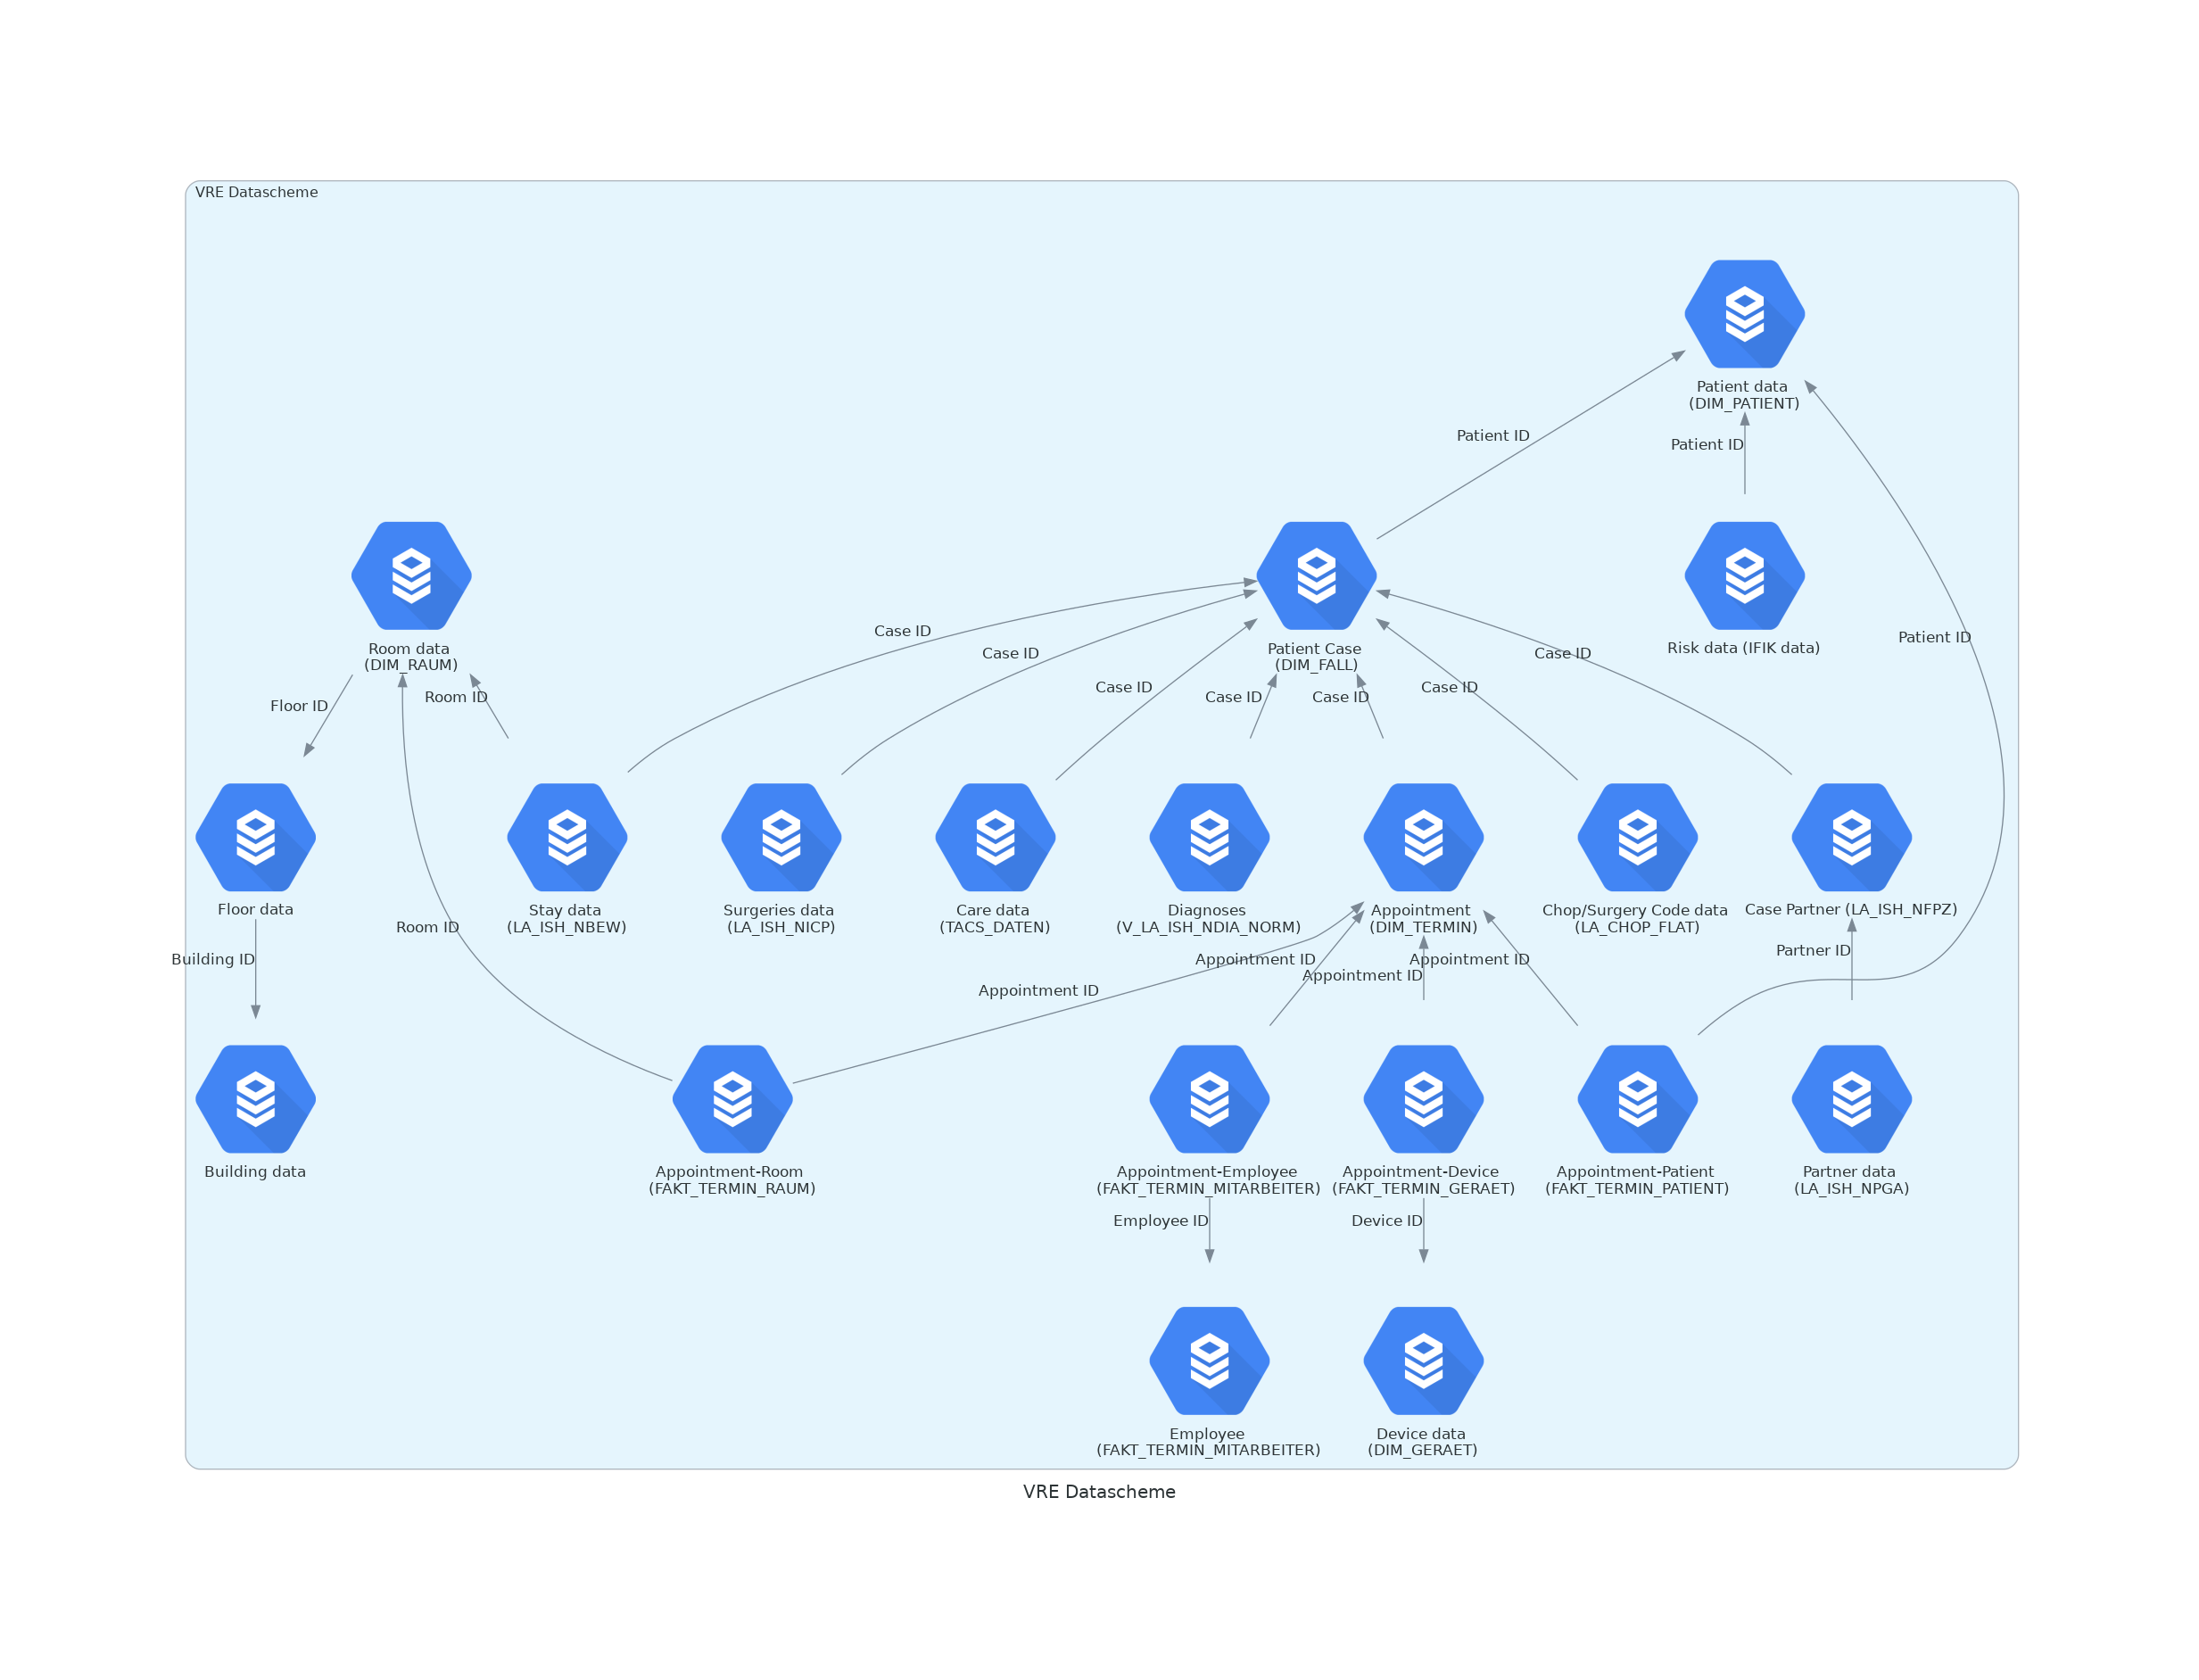

In [2]:
from diagrams import Cluster, Diagram, Edge
from diagrams.gcp.database import SQL

graph_attr = {
#     "splines": "polyline",
    "splines": "spline",
#     "splines":"curved",
    "concentrate":"true",
    "nodesep":"1.1",
}

edge_attr = {
    "minlen":"1"
}

with Diagram("VRE Datascheme", show=False, graph_attr=graph_attr, edge_attr=edge_attr, outformat='png', direction="TB") as diag:
    
    with Cluster("VRE Datascheme"):
        
        # draw edges
#       with Cluster("linked by Patient ID"):
        patient_node = SQL("Patient data \n(DIM_PATIENT)")
        risk_node = SQL("Risk data (IFIK data)")

#             with Cluster("linked by Case ID"):
        case_node = SQL("Patient Case \n(DIM_FALL)")
        stay_node = SQL("Stay data \n(LA_ISH_NBEW)")
        case_partner_node = SQL("Case Partner (LA_ISH_NFPZ)")
        partner_node = SQL("Partner data \n(LA_ISH_NPGA)")
        care_node = SQL("Care data \n(TACS_DATEN)")
        icd10_code_node = SQL("Diagnoses \n(V_LA_ISH_NDIA_NORM)")
        chop_code_node = SQL("Chop/Surgery Code data \n(LA_CHOP_FLAT)")
        surgery_node = SQL("Surgeries data \n(LA_ISH_NICP)")

#                 with Cluster("linked by Appointment ID"):
        appointment_node = SQL("Appointment \n(DIM_TERMIN)")
        appointment_patient_node = SQL("Appointment-Patient \n(FAKT_TERMIN_PATIENT)")
        appointment_device_node = SQL("Appointment-Device \n(FAKT_TERMIN_GERAET)")
        device_node = SQL("Device data \n(DIM_GERAET)")
        appointment_room_node = SQL("Appointment-Room \n(FAKT_TERMIN_RAUM)")
        appointment_employee_node = SQL("Appointment-Employee \n(FAKT_TERMIN_MITARBEITER)")
        employee_node = SQL("Employee \n(FAKT_TERMIN_MITARBEITER)")

        appointment_node << Edge(xlabel="Appointment ID") << [appointment_patient_node,
                                                             appointment_device_node,
                                                             appointment_room_node,
                                                             appointment_employee_node]
        
        appointment_device_node >> Edge(xlabel="Device ID") >> device_node
        appointment_employee_node >> Edge(xlabel="Employee ID") >> employee_node


        case_node << Edge(xlabel="Case ID") << [stay_node,
                                               case_partner_node,
                                               chop_code_node,
                                               surgery_node,
                                               appointment_node,
                                               care_node,
                                               icd10_code_node]

        case_partner_node << Edge(xlabel="Partner ID") << partner_node

        patient_node << Edge(xlabel="Patient ID") << [case_node,
                                                     risk_node,
                                                     appointment_patient_node]
            
#         with Cluster("linked by Room ID"):
        room_node = SQL("Room data \n(DIM_RAUM)")
        floor_node = SQL("Floor data")
        building_node = SQL("Building data")
        room_node >> Edge(xlabel="Floor ID") >> floor_node >> Edge(xlabel="Building ID") >> building_node
        room_node << Edge(xlabel="Room ID") << [appointment_room_node,
                                                stay_node]
    
diag

In [3]:
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('../')
os.chdir("../")

base_folder = "./data/raw/model_data/"


Bad key savefig.frameon in file /home/benelot/miniconda3/envs/vre-spark/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /home/benelot/miniconda3/envs/vre-spark/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /home/benelot/miniconda3/envs/vre-spark/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.

## Utility functions

### Get class of colums

In [4]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

def evaluate_col_classes(df):
    for column_name in df.columns:
        if is_string_dtype(df[column_name].dtype):  # the column is probably categorical if correctly encoded
            print('CATEGORICAL: Column name: {0}, dtype: {1}, values: {2}'
                  .format(column_name,
                    df[column_name].dtype,
                    df[column_name].unique()))
        elif is_numeric_dtype(df[column_name].dtype.name): # the column is probably numerical if correctly encoded
            unique_vals = df[column_name].unique()

            if len(unique_vals) > 100: # magic number
                print('NUMERICAL: Column name: {0}, dtype: {1}, #qty unique values: {2}'
                      .format(column_name,
                      df[column_name].dtype,
                      len(unique_vals)))
            else:
                print('NUMERICAL/POSSIBLY CATEGORICAL: Column name: {0}, dtype: {1}, unique values (#qty): {2}, ({3})'
                      .format(column_name,
                      df[column_name].dtype,
                      sorted(unique_vals),
                      len(unique_vals)))

        else: # what kind of type is this?
            print('UNKNOWN: Column name: {0}, dtype: {1}, class: numerical'
                  .format(column_name,
                   df[column_name].dtype))


### Plot histogram of dates

In [5]:
def plot_date_histogram_of_col(df, col="date", by_month=False):
    col_s = df[col].dropna()
    if not by_month:
        col_s.groupby([col_s.dt.year]).count().plot(kind="bar", figsize=(16,12))
    else:
        col_s.groupby([col_s.dt.year, col_s.dt.month]).count().plot(kind="bar", figsize=(16,12))

## Patient Cases (DIM_FALL)

Patients are loaded based on a case start date, which is set to '2017-01-01' (from audit.env_variables where var_name='load_date_from').

In [6]:
dim_case_df = pd.read_csv(base_folder + "DIM_FALL.csv", dtype=str, parse_dates=["BEGDT", 'ENDDT'], encoding="ISO-8859-1")

In [7]:
dim_case_df.columns = ["Patient ID", "Case ID", "Case Type ID", "Case Status", "Case Type", "Start Date", "End Date",
              "Patient Type", "Patient Status"]

In [8]:
dim_case_df.head(0)

,Patient ID,Case ID,Case Type ID,Case Status,Case Type,Start Date,End Date,Patient Type,Patient Status


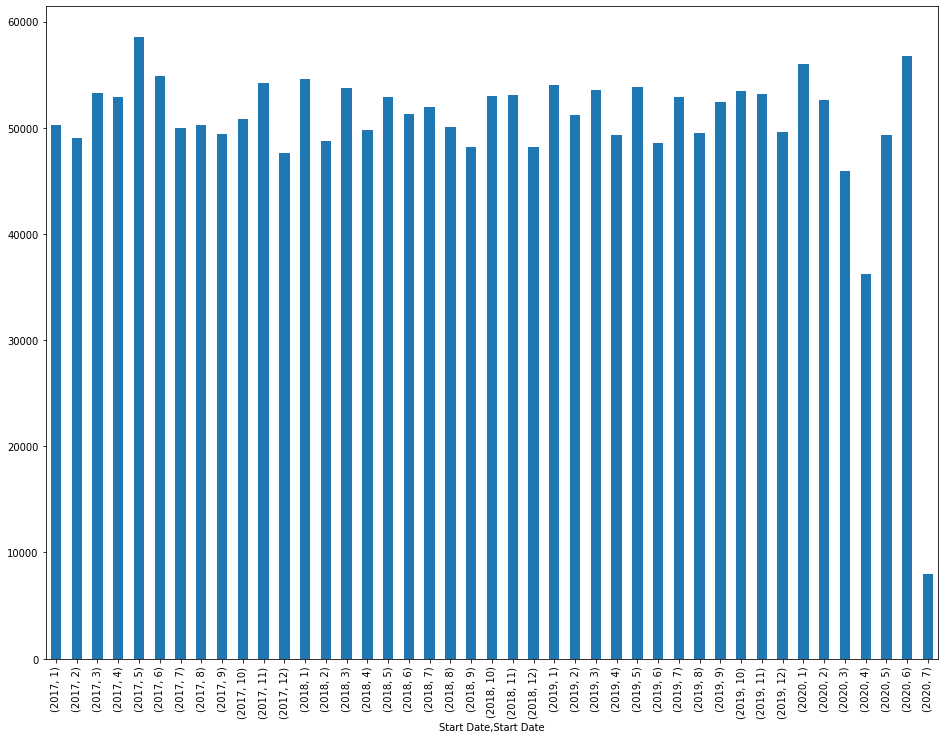

In [9]:
plot_date_histogram_of_col(dim_case_df, col="Start Date", by_month=True)

### Plot histogram of enddates

In [10]:
dim_case_df.loc[dim_case_df["End Date"].str.contains("2[4-9][0-9][0-9]-"), "End Date"] = "1753-01-01"

In [11]:
dim_case_df.loc[dim_case_df["End Date"].str.contains("[3-9][0-9][0-9][0-9]-"), "End Date"] = "1753-01-01"

In [12]:
dim_case_df["End Date"] = pd.to_datetime(dim_case_df["End Date"])

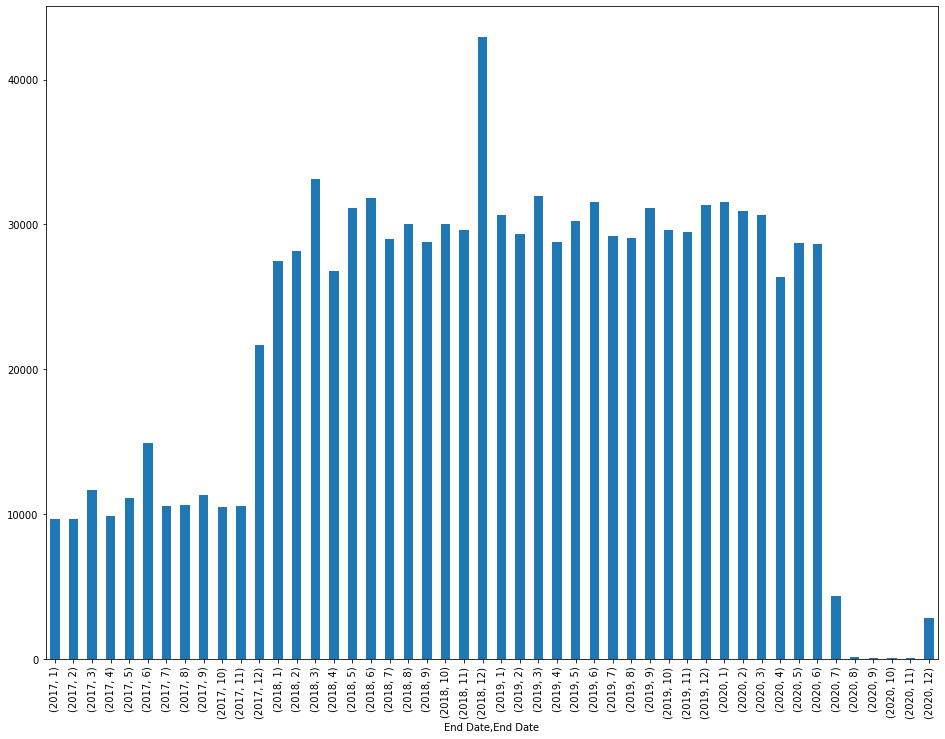

In [13]:
import datetime
plot_date_histogram_of_col(dim_case_df[(dim_case_df["End Date"] > datetime.datetime(2017, 1, 1)) & (dim_case_df["End Date"] < datetime.datetime(2021, 1, 1))], col="End Date", by_month=True)

### Evaluate data types of patient cases

In [14]:
evaluate_col_classes(dim_case_df)

CATEGORICAL: Column name: Patient ID, dtype: object, values: ['00013831402' '00013719092' '00082907641' ... '00016155874' '00082010587'
 '00013291548']
CATEGORICAL: Column name: Case ID, dtype: object, values: ['0005752785' '0005752786' '0005752787' ... '0007743118' '0007743119'
 '0007743120']
CATEGORICAL: Column name: Case Type ID, dtype: object, values: ['2' '1' '3']
CATEGORICAL: Column name: Case Status, dtype: object, values: ['Fall ist abgeschlossen' 'Fall ist aktuell' 'Fall ist im Planstatus']
CATEGORICAL: Column name: Case Type, dtype: object, values: ['ambulanter Fall' 'stationärer Fall' 'teilstationärer Fall']
UNKNOWN: Column name: Start Date, dtype: datetime64[ns], class: numerical
UNKNOWN: Column name: End Date, dtype: datetime64[ns], class: numerical
CATEGORICAL: Column name: Patient Type, dtype: object, values: [nan 'Standard Patient']
CATEGORICAL: Column name: Patient Status, dtype: object, values: [nan 'aktiv' 'storniert']


## Treatment Devices (DIM_GERAET)

In [15]:
dim_device_df = pd.read_csv(base_folder + "DIM_GERAET.csv", encoding="ISO-8859-1")

In [16]:
dim_device_df.head(0)

,dim_geraet_bk,dim_geraet_name


### Evaluate data types of treatment devices

In [17]:
evaluate_col_classes(dim_device_df)

NUMERICAL: Column name: dim_geraet_bk, dtype: int64, #qty unique values: 1279
CATEGORICAL: Column name: dim_geraet_name, dtype: object, values: ['Unknown' 'Weiss Neidhart Claudia' 'PLWC' ... 'S. Kälin' 'KMEB 4'
 'Sentinel 7-T-EKG 8']


## Patients (DIM_PATIENT)

In [18]:
dim_patient_df = pd.read_csv(base_folder + "DIM_PATIENT.csv", dtype=str, encoding="ISO-8859-1", header=None)

In [19]:
dim_patient_df.columns = ["Patient ID", "Gender", "Birth date", "Zip Code", "City", "Canton", "Language"]

In [20]:
dim_patient_df["Birth date"] = pd.to_datetime(dim_patient_df["Birth date"])

In [21]:
dim_patient_df.head(0)

,Patient ID,Gender,Birth date,Zip Code,City,Canton,Language


### Plot histogram of birthdates

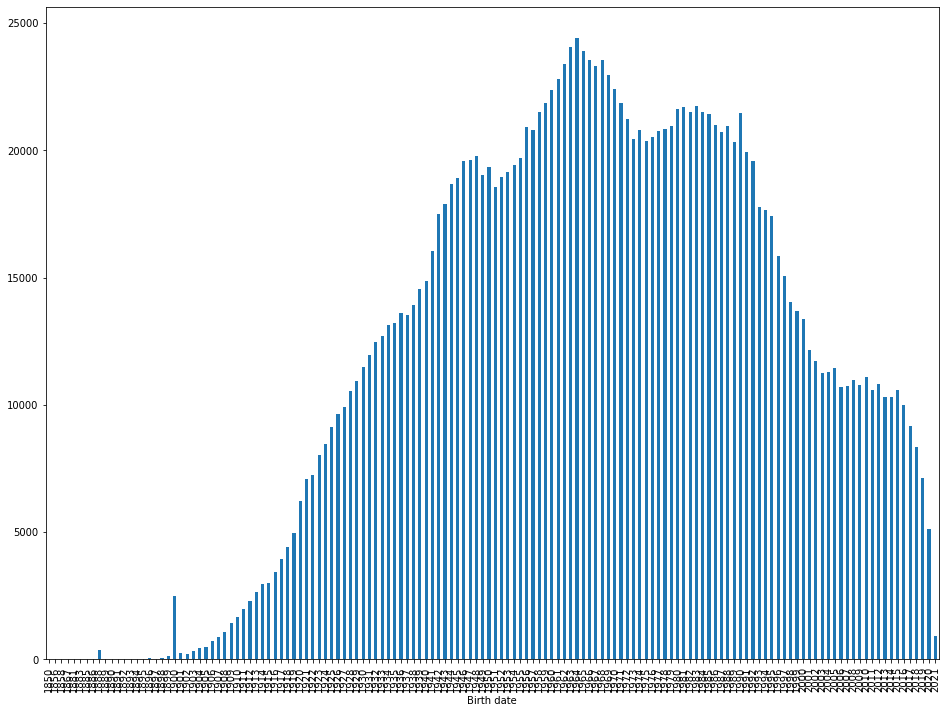

In [22]:
plot_date_histogram_of_col(dim_patient_df[dim_patient_df["Birth date"] > datetime.datetime(1850,1,1)], col="Birth date", by_month=False)

Looks like a demographic curve. So that is all great.

### Plot pretty unrealistic birth dates in the table

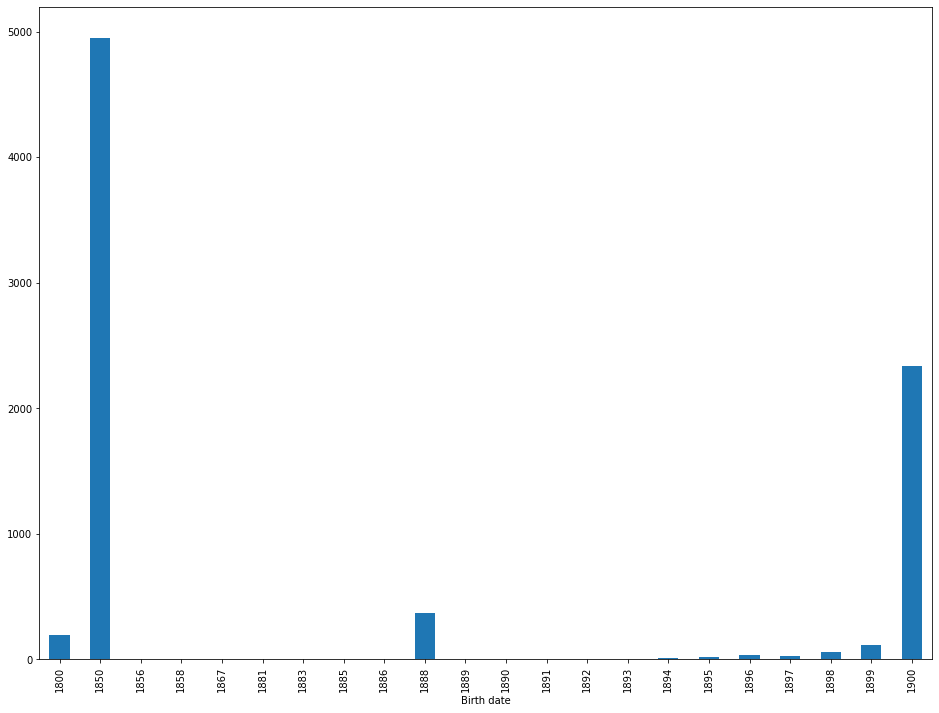

In [23]:
condition = (dim_patient_df["Birth date"] <= pd.to_datetime("1900-01-01")) & (dim_patient_df["Birth date"] > pd.to_datetime("1754-01-01"))
plot_date_histogram_of_col(dim_patient_df[condition], col="Birth date", by_month=False)

Some of those seem to be dates mean to be placeholders, but they are a bit fancy.

### Evaluate data types of patient data

In [24]:
evaluate_col_classes(dim_patient_df)

CATEGORICAL: Column name: Patient ID, dtype: object, values: ['ï»¿-' '00000000051' '00000000078' ... 'P0001503392' 'P0001503405'
 'P0001503497']
CATEGORICAL: Column name: Gender, dtype: object, values: [nan 'weiblich' 'mÃ¤nnlich' 'Unknown']
UNKNOWN: Column name: Birth date, dtype: datetime64[ns], class: numerical
CATEGORICAL: Column name: Zip Code, dtype: object, values: [nan '4950' '3053' ... '1787 PK' '98005' '50140']
CATEGORICAL: Column name: City, dtype: object, values: [nan 'Huttwil' 'MÃ¼nchenbuchsee' ... 'Julianadorp' 'Bellevue (WA)'
 'Amphoe Saraphi Provinz Ching Mai']
CATEGORICAL: Column name: Canton, dtype: object, values: [nan 'BE' 'OW' 'VS' 'AG' 'SO' 'FR' 'LU' 'TI' 'NE' 'BS' 'VD' 'ZH' 'DE' 'JU'
 'SG' 'IT' 'UR' 'SZ' 'SH' 'GR' 'GE' 'BL' 'AR' 'TH' 'CO' 'ZG' 'NW' 'TG'
 'GL' 'FL' 'GB' 'ES' 'YU' 'AI' 'AT' 'KW' 'TO' 'BD' 'NL' 'QA' 'LY' 'US'
 'PT' 'PL' 'CE' 'PH' 'EC' 'KE' 'TR' 'ZA' 'SA' 'BR' 'VE' 'HR' 'LB' 'MC'
 'CR' 'WA' 'ML' 'PK' '38' 'EG' 'RO' '08' 'SK' 'AE' 'NO' 'BG' 'RU' 'PY'
 

## DIM_RAUM

In [25]:
dim_room_df = pd.read_csv(base_folder + "DIM_RAUM.csv", encoding="ISO-8859-1")

In [26]:
dim_room_df.columns = ["Room ID", "Room Common Name"]

In [27]:
dim_room_df.head(0)

,Room ID,Room Common Name


In [28]:
evaluate_col_classes(dim_room_df)

#dim_room_df.sort_values(by='RAUMNAME')["RAUMNAME"].to_list()

NUMERICAL: Column name: Room ID, dtype: int64, #qty unique values: 1394
CATEGORICAL: Column name: Room Common Name, dtype: object, values: ['Unknown' 'Dermatologie (Eingang 14D)' 'Überwachung_B108b' ...
 'Studienkoje' 'BZ Studie' 'vorübergehend Sitzungsraum ASH 202']


## DIM_TERMIN

In [29]:
dim_appointment_df = pd.read_csv(base_folder + "DIM_TERMIN.csv", dtype=str, parse_dates=["TERMINDATUM"], encoding="ISO-8859-1")

In [30]:
dim_appointment_df.columns = ["Appointment ID", "Deleted On Source", "Description", "Type", "Type 2", "Date", "Duration in Minutes"]

In [31]:
dim_appointment_df.head(0)

,Appointment ID,Deleted On Source,Description,Type,Type 2,Date,Duration in Minutes


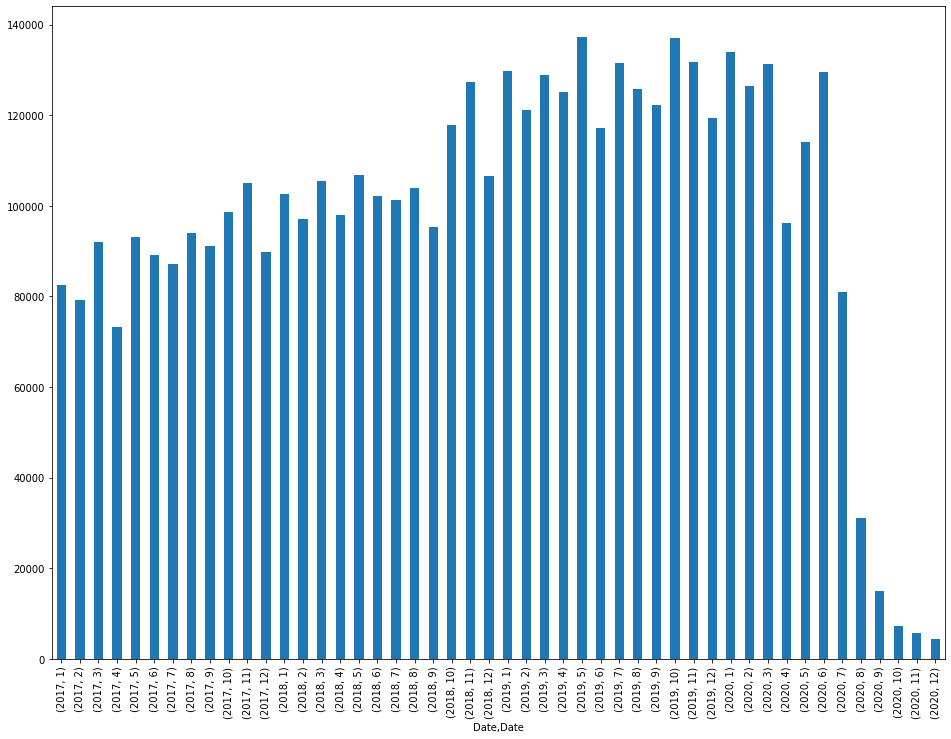

In [32]:
plot_date_histogram_of_col(dim_appointment_df[(dim_appointment_df["Date"] > datetime.datetime(2017, 1, 1)) & (dim_appointment_df["Date"] < datetime.datetime(2021, 1, 1))], col="Date", by_month=True)

In [33]:
evaluate_col_classes(dim_appointment_df)

CATEGORICAL: Column name: Appointment ID, dtype: object, values: ['19413075' '19328264' '21767699' ... '46756892' '46756896' '46756905']
CATEGORICAL: Column name: Deleted On Source, dtype: object, values: ['False' 'True']
CATEGORICAL: Column name: Description, dtype: object, values: ['KONS + BE + FIBROSCAN' 'Lucentisinjektion OS  8. IVT'
 'Fuss*\r\r\n Poli Verlaufspatient Röntgen' ...
 'NSTEMI aus Pourtales, Beschwerdebeginn heute Morgen 8 Uhr, aktuell noch leichte Beschwerden, ASS und Arixtra in Pourtales erhalten, EKG mit ST-Senkungen V5 V6, Bett auf P-IMC'
 'Abszess periimplantär Mamma R \r\r\nAbszess I & D und Explantation '
 'SV Dig III links (dom)  Wundexploration +/- Gefäss/Sehnen/Nervennaht, +/- Avance, +/- Palmaris Longus Entnahme von R  ']
CATEGORICAL: Column name: Type, dtype: object, values: ['KONS + BE + FIBROSCAN' 'Lucentisinjektion OS' 'Fuss Verlauf Röntgen' ...
 'Transfer' 'Kinderrheuma 30` ' 'K30AT130']
CATEGORICAL: Column name: Type 2, dtype: object, values: ['Patient

## FAKT_MEDIKAMENTE

In [34]:
fact_medication_df = pd.read_csv(base_folder + "FAKT_MEDIKAMENTE.csv", dtype=str, parse_dates=["DRUG_SUBMISSION"], encoding="ISO-8859-1")

In [35]:
fact_medication_df.head(0)

,PATIENTID,CASEID,DRUG_TEXT,DRUG_ATC,DRUG_QUANTITY,DRUG_UNIT,DRUG_DISPFORM,DRUG_SUBMISSION


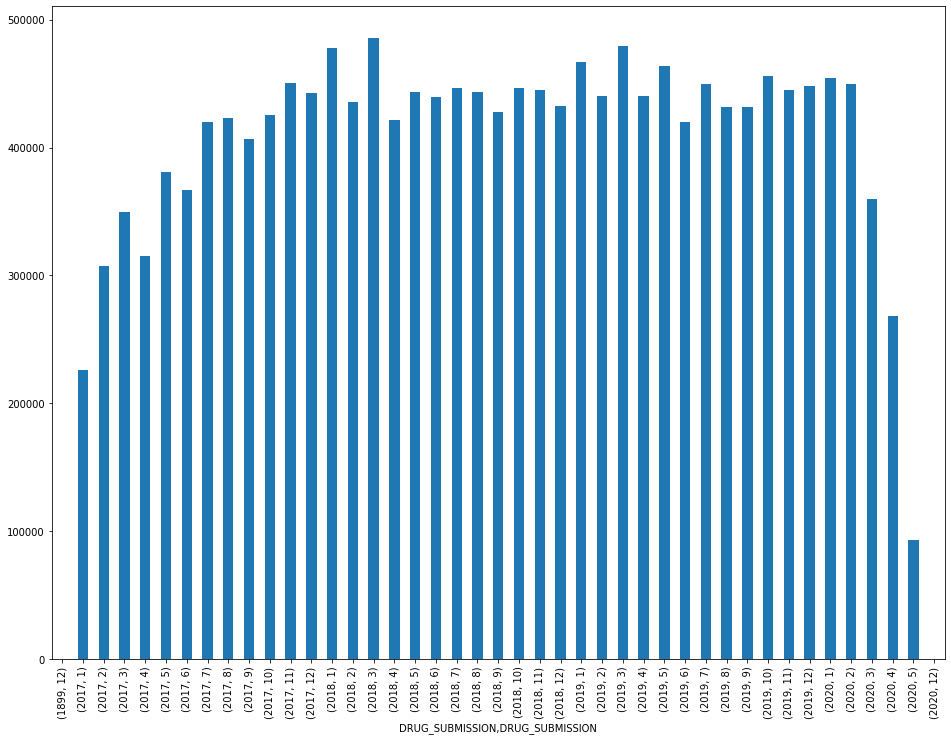

In [36]:
plot_date_histogram_of_col(fact_medication_df, col="DRUG_SUBMISSION", by_month=True)

In [37]:
evaluate_col_classes(fact_medication_df)

CATEGORICAL: Column name: PATIENTID, dtype: object, values: ['00004075684' '00000678244' '00012742392' ... '00002392852' '00015782212'
 '00015840590']
CATEGORICAL: Column name: CASEID, dtype: object, values: ['0006539951' '0007285187' '0007282359' ... '0007613374' '0007406742'
 '0007456467']
CATEGORICAL: Column name: DRUG_TEXT, dtype: object, values: ['Novalgin' 'Aspirin Cardio' 'Pantoprazol' ... 'Alges-X' 'Inflectra'
 'Tavor']
CATEGORICAL: Column name: DRUG_ATC, dtype: object, values: ['N02BB02' 'B01AC06' 'A02BC02' ... 'S02DZ' 'A06A' 'B05AA06']
CATEGORICAL: Column name: DRUG_QUANTITY, dtype: object, values: ['1.0' '2.0' '4.0' ... '24970.5' '-333.33333333333303'
 '141.42857142857102']
CATEGORICAL: Column name: DRUG_UNIT, dtype: object, values: ['500 mg/1 Stk' '100 mg/1 Stk' '40 mg/1 Stk' ... '1 g/1 g'
 '0.6 ml/1 ml, 0.15 ml/1 ml, 0.25 ml/1 ml' '1.5 mcg/1 Stk']
CATEGORICAL: Column name: DRUG_DISPFORM, dtype: object, values: ['p.o. (peroral)' 'i.v. (intravenös; Injektion)' 'i.v. (intrave

## FAKT_TERMIN_GERAET

In [38]:
fact_appointment_device_df = pd.read_csv(base_folder + "FAKT_TERMIN_GERAET.csv", dtype=str, parse_dates=["TERMINSTART_TS", "TERMINENDE_TS"], encoding="ISO-8859-1")

In [39]:
fact_appointment_device_df

,TERMINID,GERAETID,TERMINSTART_TS,TERMINENDE_TS,DAUERINMIN
0,41284049,58605,2019-02-01 08:00:00.0000000,2019-02-01 08:15:00.0000000,15.000000
1,41284049,58606,2019-02-01 09:15:00.0000000,2019-02-01 10:15:00.0000000,60.000000
2,44555168,21165,2020-01-08 09:30:00.0000000,2020-01-08 09:45:00.0000000,15.000000
3,44555296,125975,2019-11-18 08:54:00.0000000,2019-11-18 08:59:00.0000000,5.000000
4,44555317,178345,2019-11-18 14:00:00.0000000,2019-11-18 15:00:00.0000000,60.000000
...,...,...,...,...,...
3716896,NaN,63397,2010-04-01 10:00:00.0000000,2010-04-01 11:00:00.0000000,60.000000
3716897,NaN,101550,2010-06-24 14:30:00.0000000,2010-06-24 14:45:00.0000000,15.000000
3716898,NaN,123219,2011-01-03 11:00:00.0000000,2011-01-03 12:00:00.0000000,60.000000
3716899,NaN,21852,2011-04-11 09:30:00.0000000,2011-04-11 09:45:00.0000000,15.000000


In [40]:
fact_appointment_device_df.loc[fact_appointment_device_df["TERMINSTART_TS"].str.contains("1[0-6][0-9][0-9]-"), "TERMINSTART_TS"] = "1753-01-01"

In [41]:
fact_appointment_device_df.loc[fact_appointment_device_df["TERMINSTART_TS"].str.contains("2[4-9][0-9][0-9]-"), "TERMINSTART_TS"] = "1753-01-01"

In [42]:
fact_appointment_device_df.loc[fact_appointment_device_df["TERMINSTART_TS"].str.contains("[3-9][0-9][0-9][0-9]-"), "TERMINSTART_TS"] = "1753-01-01"

In [43]:
fact_appointment_device_df.loc[fact_appointment_device_df["TERMINSTART_TS"].str.contains("0[0-9][0-9][0-9]-"), "TERMINSTART_TS"] = "1753-01-01"

In [44]:
fact_appointment_device_df["TERMINSTART_TS"] = pd.to_datetime(fact_appointment_device_df["TERMINSTART_TS"])

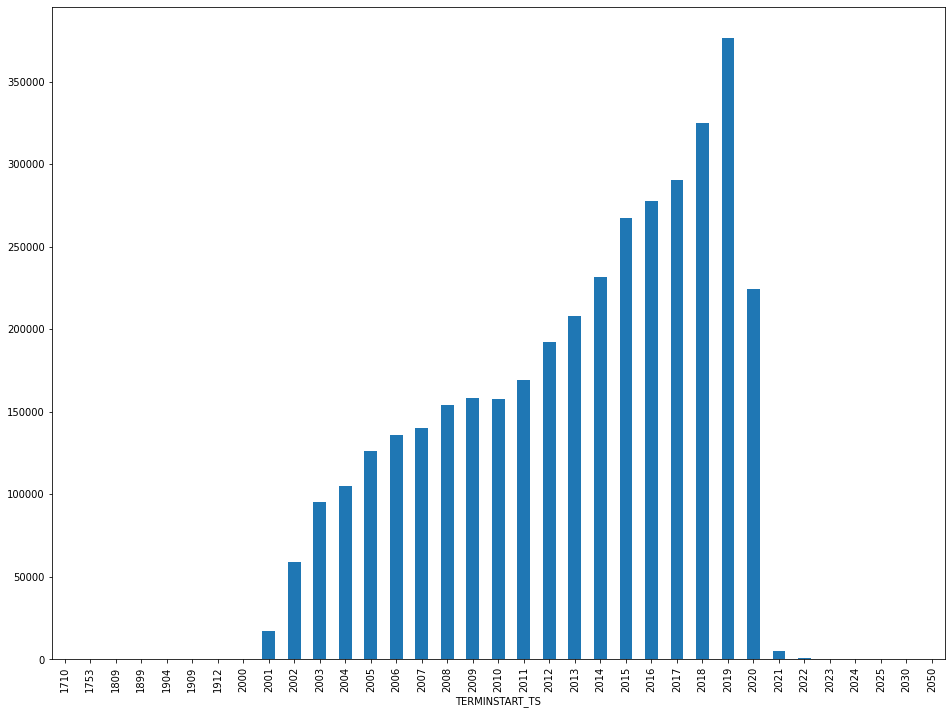

In [45]:
plot_date_histogram_of_col(fact_appointment_device_df, col="TERMINSTART_TS", by_month=False)

In [46]:
fact_appointment_device_df.loc[fact_appointment_device_df["TERMINENDE_TS"].str.contains("1[0-6][0-9][0-9]-"), "TERMINENDE_TS"] = "1753-01-01"

In [47]:
fact_appointment_device_df.loc[fact_appointment_device_df["TERMINENDE_TS"].str.contains("2[4-9][0-9][0-9]-"), "TERMINENDE_TS"] = "1753-01-01"

In [48]:
fact_appointment_device_df.loc[fact_appointment_device_df["TERMINENDE_TS"].str.contains("[3-9][0-9][0-9][0-9]-"), "TERMINENDE_TS"] = "1753-01-01"

In [49]:
fact_appointment_device_df.loc[fact_appointment_device_df["TERMINENDE_TS"].str.contains("0[0-9][0-9][0-9]-"), "TERMINENDE_TS"] = "1753-01-01"

In [50]:
fact_appointment_device_df["TERMINENDE_TS"] = pd.to_datetime(fact_appointment_device_df["TERMINENDE_TS"])

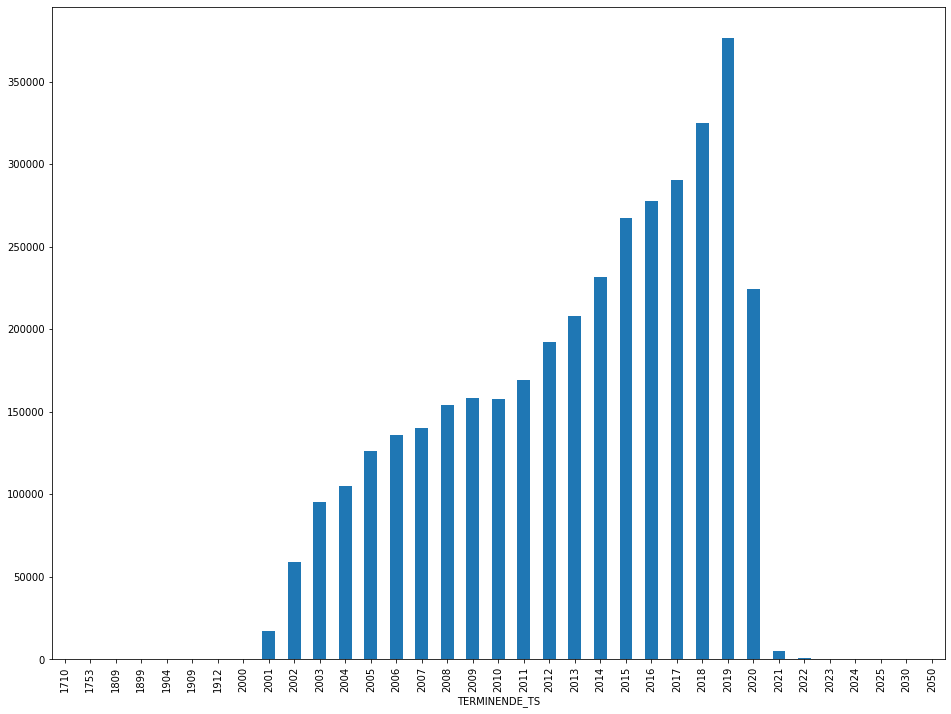

In [51]:
plot_date_histogram_of_col(fact_appointment_device_df, col="TERMINENDE_TS", by_month=False)

In [52]:
evaluate_col_classes(fact_appointment_device_df)

CATEGORICAL: Column name: TERMINID, dtype: object, values: ['41284049' '44555168' '44555296' ... '37891280' '37891526' '35946080']
CATEGORICAL: Column name: GERAETID, dtype: object, values: ['58605' '58606' '21165' ... '172567' '46074' '177534']
UNKNOWN: Column name: TERMINSTART_TS, dtype: datetime64[ns], class: numerical
UNKNOWN: Column name: TERMINENDE_TS, dtype: datetime64[ns], class: numerical
CATEGORICAL: Column name: DAUERINMIN, dtype: object, values: ['15.000000' '60.000000' '5.000000' ... '1404.000000' '968.000000'
 '803.000000']


## FAKT_TERMIN_MITARBEITER

In [53]:
fact_appointment_employee_df = pd.read_csv(base_folder + "FAKT_TERMIN_MITARBEITER.csv", dtype=str, parse_dates=["TERMINSTART_TS", "TERMINENDE_TS"], encoding="ISO-8859-1")

In [54]:
fact_appointment_employee_df

,TERMINID,MITARBEITERID,TERMINSTART_TS,TERMINENDE_TS,DAUERINMIN
0,NaN,3287,2016-11-17 10:40:00.0000000,2016-11-17 12:10:00.0000000,90.000000
1,36785853,171943,2017-11-15 11:00:00.0000000,2017-11-15 11:30:00.0000000,30.000000
2,NaN,60474,2006-09-15 11:30:00.0000000,2006-09-15 12:00:00.0000000,30.000000
3,NaN,65901,2009-08-18 11:00:00.0000000,2009-08-18 11:30:00.0000000,30.000000
4,32895570,104887,2017-03-31 09:45:00.0000000,2017-03-31 10:00:00.0000000,15.000000
...,...,...,...,...,...
7731206,46167840,161033,2020-05-18 13:09:00.0000000,2020-05-18 13:24:00.0000000,15.000000
7731207,NaN,89225,2015-08-13 13:30:00.0000000,2015-08-13 14:30:00.0000000,60.000000
7731208,45689658,133843,2020-03-12 15:00:00.0000000,2020-03-12 15:45:00.0000000,45.000000
7731209,42054932,172284,2019-02-19 10:15:00.0000000,2019-02-19 11:00:00.0000000,45.000000


In [55]:
fact_appointment_employee_df.loc[fact_appointment_employee_df["TERMINSTART_TS"].str.contains("1[0-6][0-9][0-9]-"), "TERMINSTART_TS"] = "1753-01-01"

In [56]:
fact_appointment_employee_df.loc[fact_appointment_employee_df["TERMINSTART_TS"].str.contains("2[4-9][0-9][0-9]-"), "TERMINSTART_TS"] = "1753-01-01"

In [57]:
fact_appointment_employee_df.loc[fact_appointment_employee_df["TERMINSTART_TS"].str.contains("[3-9][0-9][0-9][0-9]-"), "TERMINSTART_TS"] = "1753-01-01"

In [58]:
fact_appointment_employee_df.loc[fact_appointment_employee_df["TERMINSTART_TS"].str.contains("0[0-9][0-9][0-9]-"), "TERMINSTART_TS"] = "1753-01-01"

In [59]:
fact_appointment_employee_df["TERMINSTART_TS"] = pd.to_datetime(fact_appointment_employee_df["TERMINSTART_TS"])

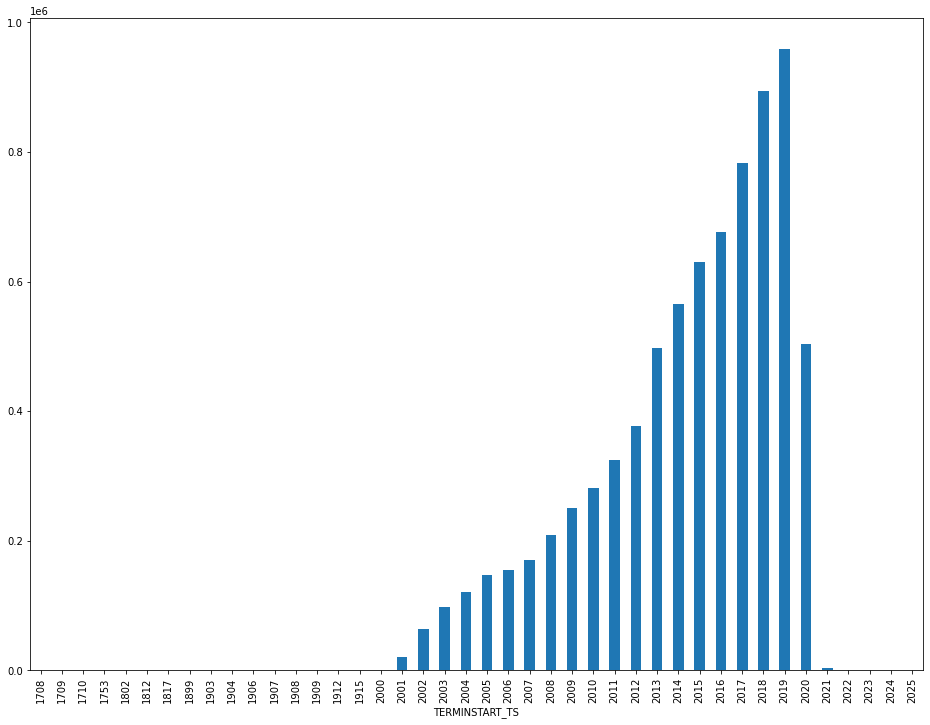

In [60]:
plot_date_histogram_of_col(fact_appointment_employee_df, col="TERMINSTART_TS", by_month=False)

In [61]:
fact_appointment_employee_df.loc[fact_appointment_employee_df["TERMINENDE_TS"].str.contains("1[0-6][0-9][0-9]-"), "TERMINENDE_TS"] = "1753-01-01"

In [62]:
fact_appointment_employee_df.loc[fact_appointment_employee_df["TERMINENDE_TS"].str.contains("2[4-9][0-9][0-9]-"), "TERMINENDE_TS"] = "1753-01-01"

In [63]:
fact_appointment_employee_df.loc[fact_appointment_employee_df["TERMINENDE_TS"].str.contains("[3-9][0-9][0-9][0-9]-"), "TERMINENDE_TS"] = "1753-01-01"

In [64]:
fact_appointment_employee_df.loc[fact_appointment_employee_df["TERMINENDE_TS"].str.contains("0[0-9][0-9][0-9]-"), "TERMINENDE_TS"] = "1753-01-01"

In [65]:
fact_appointment_employee_df["TERMINENDE_TS"] = pd.to_datetime(fact_appointment_employee_df["TERMINENDE_TS"])

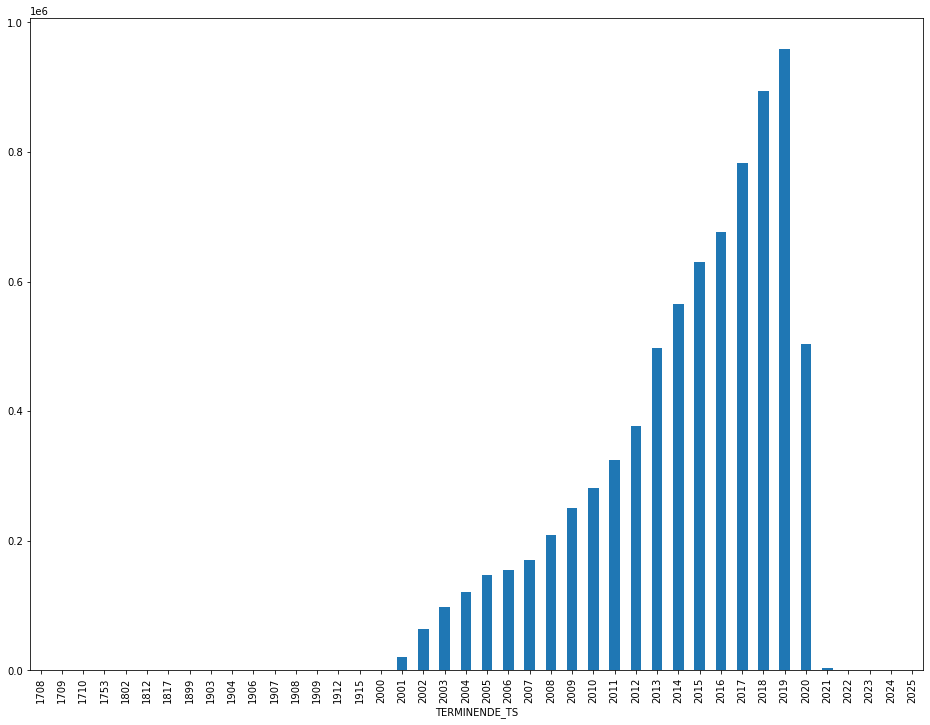

In [66]:
plot_date_histogram_of_col(fact_appointment_employee_df, col="TERMINENDE_TS", by_month=False)

In [67]:
evaluate_col_classes(fact_appointment_employee_df)

CATEGORICAL: Column name: TERMINID, dtype: object, values: [nan '36785853' '32895570' ... '39457008' '45689658' '42054932']
CATEGORICAL: Column name: MITARBEITERID, dtype: object, values: ['3287' '171943' '60474' ... '179449' '131987' '137099']
UNKNOWN: Column name: TERMINSTART_TS, dtype: datetime64[ns], class: numerical
UNKNOWN: Column name: TERMINENDE_TS, dtype: datetime64[ns], class: numerical
CATEGORICAL: Column name: DAUERINMIN, dtype: object, values: ['90.000000' '30.000000' '15.000000' ... '-18.000000' '2890.000000'
 '1239.000000']


## FAKT_TERMIN_PATIENT

In [68]:
fact_appointment_patient_df = pd.read_csv(base_folder + "FAKT_TERMIN_PATIENT.csv", dtype=str, encoding="ISO-8859-1")

In [69]:
fact_appointment_patient_df

,TERMINID,PATIENTID,FALLID
0,36846470,00003236501,0006102488
1,36544102,00013905627,0006134814
2,38089011,00000737399,0006761749
3,42256731,00008800596,0007100236
4,38853440,00014458004,0006396378
...,...,...,...
1117260,43149542,00009683054,0007150446
1117261,42171803,00007150741,0006917305
1117262,42914212,00007051727,0006940820
1117263,42151452,00015193209,0006919338


In [70]:
evaluate_col_classes(fact_appointment_patient_df)

CATEGORICAL: Column name: TERMINID, dtype: object, values: ['36846470' '36544102' '38089011' ... '42914212' '42151452' '42325315']
CATEGORICAL: Column name: PATIENTID, dtype: object, values: ['00003236501' '00013905627' '00000737399' ... '00015056104' '00002538598'
 '00015315525']
CATEGORICAL: Column name: FALLID, dtype: object, values: ['0006102488' '0006134814' '0006761749' ... '0007003587' '0007717572'
 '0007043663']


## FAKT_TERMIN_RAUM

In [71]:
fact_appointment_room_df = pd.read_csv(base_folder + "FAKT_TERMIN_RAUM.csv", dtype=str, parse_dates=["TERMINSTART_TS", "TERMINENDE_TS"], encoding="ISO-8859-1")

In [72]:
fact_appointment_room_df

,TERMINID,RAUMID,RAUMNAME,TERMINSTART_TS,TERMINENDE_TS,DAUERINMIN
0,39089851,138511,Sprechzimmer 9: 2 63 50,2018-06-11 14:30:00,2018-06-11 15:00:00,30.000000
1,46264649,154106,Erb Ber 1,2020-07-28 16:00:00,2020-07-28 17:00:00,60.000000
2,41404123,160034,Orth Koje 2,2019-01-17 10:30:00,2019-01-17 11:00:00,30.000000
3,44410006,58665,Raum C 321,2019-11-04 15:00:00,2019-11-04 15:30:00,30.000000
4,34619189,140367,BZ Koje 8,2017-05-16 14:15:00,2017-05-16 14:47:00,32.000000
...,...,...,...,...,...,...
4227171,35490217,169842,TIE_EKG 1,2017-06-15 14:30:00,2017-06-15 15:15:00,45.000000
4227172,40008239,125469,DEKL,2018-07-23 10:15:00,2018-07-23 10:45:00,30.000000
4227173,42300530,120348,INO OP 15,2019-03-22 17:30:00,2019-03-22 17:45:00,15.000000
4227174,44155554,180733,BE,2019-10-23 09:00:00,2019-10-23 09:30:00,30.000000


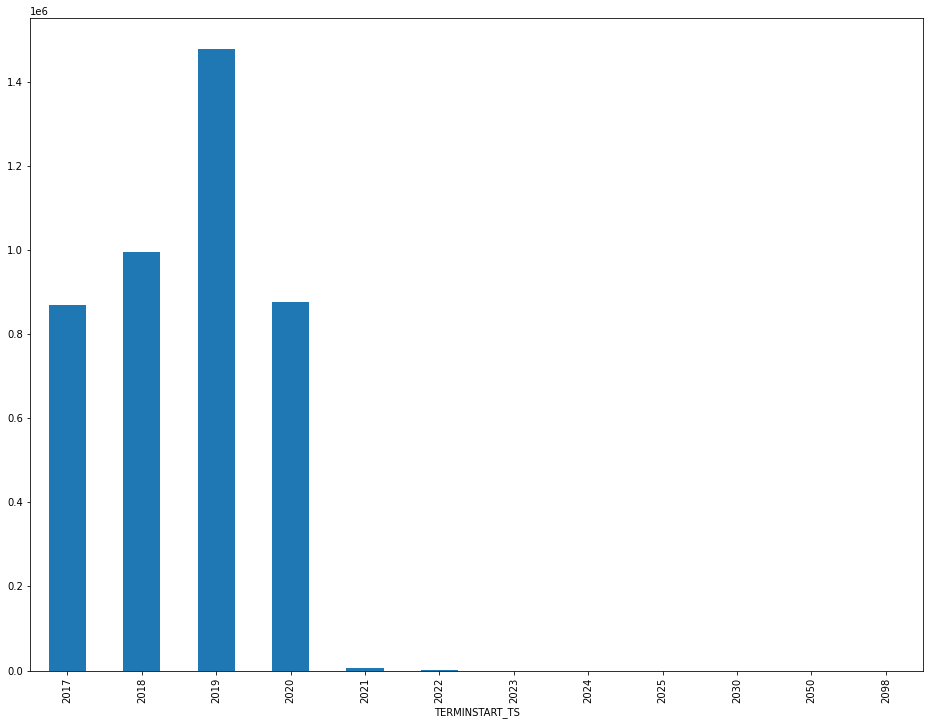

In [73]:
plot_date_histogram_of_col(fact_appointment_room_df, col="TERMINSTART_TS", by_month=False)

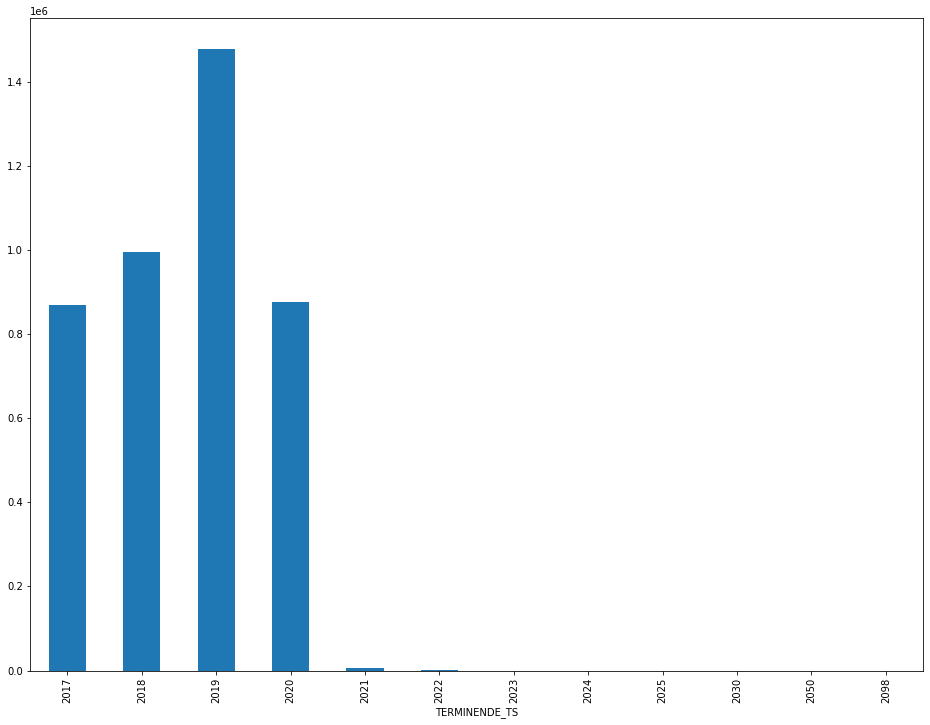

In [74]:
plot_date_histogram_of_col(fact_appointment_room_df, col="TERMINENDE_TS", by_month=False)

In [75]:
fact_appointment_room_df.sort_values(by="DAUERINMIN")

,TERMINID,RAUMID,RAUMNAME,TERMINSTART_TS,TERMINENDE_TS,DAUERINMIN
3924782,40506872,124483,Uro U 58/U1,2018-09-14 10:56:00,2018-09-14 10:55:00,-1.000000
1649057,36824819,124482,Uro U 78/U1,2017-09-21 14:11:00,2017-09-21 14:10:00,-1.000000
1556113,43015702,124482,Uro U 78/U1,2019-06-05 09:26:00,2019-06-05 09:25:00,-1.000000
1219302,39689026,124483,Uro U 58/U1,2018-06-25 08:45:00,2018-06-25 08:44:00,-1.000000
4001156,39251285,90409,INO OP 06,2018-04-22 21:00:00,2018-04-22 20:59:00,-1.000000
...,...,...,...,...,...,...
1143196,35866323,126593,IB BHH,2017-07-04 00:00:00,2017-07-04 16:30:00,990.000000
1870190,34999228,126593,IB BHH,2017-05-14 00:00:00,2017-05-14 16:30:00,990.000000
55744,42122369,126798,319,2019-03-05 16:30:00,2019-03-12 13:45:00,9915.000000
211697,39259321,127804,INO OP 03,2018-04-27 07:25:00,2018-04-27 23:57:00,992.000000


In [76]:
fact_appointment_room_df["DAUERINMIN"] = pd.to_numeric(fact_appointment_room_df["DAUERINMIN"])

<AxesSubplot:ylabel='Frequency'>

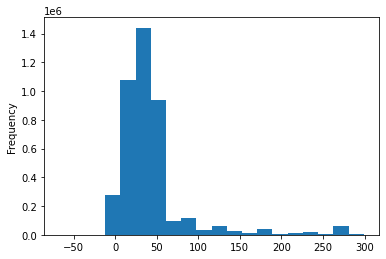

In [77]:
fact_appointment_room_df[fact_appointment_room_df["DAUERINMIN"] < 300]["DAUERINMIN"].plot.hist(bins=20)

In [78]:
# fact_appointment_room_df[(fact_appointment_room_df["DAUERINMIN"] > 300) & (fact_appointment_room_df["DAUERINMIN"] < 800)]["DAUERINMIN"].plot.hist(bins=3)

In [79]:
evaluate_col_classes(fact_appointment_room_df)

CATEGORICAL: Column name: TERMINID, dtype: object, values: ['39089851' '46264649' '41404123' ... '42972387' '35490217' '39375459']
CATEGORICAL: Column name: RAUMID, dtype: object, values: ['138511' '154106' '160034' ... '131257' '19010' '61879']
CATEGORICAL: Column name: RAUMNAME, dtype: object, values: ['Sprechzimmer 9: 2 63 50' 'Erb Ber 1' 'Orth Koje 2' ...
 'Handtherapie A 432' 'SCTA CT' 'Raum 1']
UNKNOWN: Column name: TERMINSTART_TS, dtype: datetime64[ns], class: numerical
UNKNOWN: Column name: TERMINENDE_TS, dtype: datetime64[ns], class: numerical
NUMERICAL: Column name: DAUERINMIN, dtype: float64, #qty unique values: 1097


## LA_CHOP_FLAT

In [80]:
chop_surgical_procedures_code_df = pd.read_csv(base_folder + "LA_CHOP_FLAT.csv", encoding="ISO-8859-1")

In [81]:
chop_surgical_procedures_code_df

,CHOPCODE,CHOPVERWENDUNGSJAHR,CHOP,CHOPCODELEVEL1,CHOPLEVEL1,CHOPCODELEVEL2,CHOPLEVEL2,CHOPCODELEVEL3,CHOPLEVEL3,CHOPCODELEVEL4,CHOPLEVEL4,CHOPCODELEVEL5,CHOPLEVEL5,CHOPCODELEVEL6,CHOPLEVEL6,CHOPSTATUS,CHOPSAPKATALOGID
0,C0,2009,Massnahmen und Interventionen nicht anderswo K...,C0,Massnahmen und Interventionen nicht anderswo K...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
1,C0,2010,Massnahmen und Interventionen nicht anderswo k...,C0,Massnahmen und Interventionen nicht anderswo k...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2,C0,2011,Massnahmen und Interventionen nicht anderswo K...,C0,Massnahmen und Interventionen nicht anderswo K...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
3,C0,2012,Massnahmen und Interventionen nicht anderswo K...,C0,Massnahmen und Interventionen nicht anderswo K...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,11
4,C0,2013,Massnahmen und Interventionen nicht anderswo K...,C0,Massnahmen und Interventionen nicht anderswo K...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168504,ZBB.1M,2020,"Zusatzaufwand in der Rehabilitation, mindesten...",C18,Rehabilitation (BA-BB),ZBB,Zusatzaufwand in der Rehabilitation,ZBB.1,"Zusatzaufwand in der Rehabilitation, nach Aufw...",ZBB.1M,"Zusatzaufwand in der Rehabilitation, mindesten...",NaN,NaN,NaN,NaN,1.0,20
168505,ZBB.1N,2020,"Zusatzaufwand in der Rehabilitation, mindesten...",C18,Rehabilitation (BA-BB),ZBB,Zusatzaufwand in der Rehabilitation,ZBB.1,"Zusatzaufwand in der Rehabilitation, nach Aufw...",ZBB.1N,"Zusatzaufwand in der Rehabilitation, mindesten...",NaN,NaN,NaN,NaN,1.0,20
168506,ZBB.1O,2020,"Zusatzaufwand in der Rehabilitation, mindesten...",C18,Rehabilitation (BA-BB),ZBB,Zusatzaufwand in der Rehabilitation,ZBB.1,"Zusatzaufwand in der Rehabilitation, nach Aufw...",ZBB.1O,"Zusatzaufwand in der Rehabilitation, mindesten...",NaN,NaN,NaN,NaN,1.0,20
168507,ZBB.1P,2020,"Zusatzaufwand in der Rehabilitation, mindesten...",C18,Rehabilitation (BA-BB),ZBB,Zusatzaufwand in der Rehabilitation,ZBB.1,"Zusatzaufwand in der Rehabilitation, nach Aufw...",ZBB.1P,"Zusatzaufwand in der Rehabilitation, mindesten...",NaN,NaN,NaN,NaN,1.0,20


In [82]:
evaluate_col_classes(chop_surgical_procedures_code_df)

CATEGORICAL: Column name: CHOPCODE, dtype: object, values: ['C0' 'C1' 'C10' ... 'ZBB.1O' 'ZBB.1P' 'ZBB.1Q']
NUMERICAL/POSSIBLY CATEGORICAL: Column name: CHOPVERWENDUNGSJAHR, dtype: int64, unique values (#qty): [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], (12)
CATEGORICAL: Column name: CHOP, dtype: object, values: ['Massnahmen und Interventionen nicht anderswo Klassifizierbar (00)'
 'Massnahmen und Interventionen nicht anderswo klassifizierbar (00)'
 'Operationen am Nervensystem (01\x9605)' ...
 'Zusatzaufwand in der Rehabilitation, mindestens 601 bis 650 Aufwandspunkte'
 'Zusatzaufwand in der Rehabilitation, mindestens 651 bis 700 Aufwandspunkte'
 'Zusatzaufwand in der Rehabilitation, 701 und mehr Aufwandspunkte']
CATEGORICAL: Column name: CHOPCODELEVEL1, dtype: object, values: ['C0' 'C1' 'C10' 'C11' 'C12' 'C13' 'C14' 'C15' 'C16' 'C17' 'C18' 'C2' 'C3'
 'C4' 'C5' 'C6' 'C7' 'C8' 'C9']
CATEGORICAL: Column name: CHOPLEVEL1, dtype: object, values: ['Massnahmen u

## LA_ISH_NBEW

In [83]:
movement_df = pd.read_csv(base_folder + "LA_ISH_NBEW.csv", dtype=str, parse_dates=["BWIDT", "BWEDT"], encoding="ISO-8859-1")

In [84]:
movement_df

,FALNR,LFDNR,BEWTY,BWART,BWIDT,BWIZT,STATU,BWEDT,BWEZT,LFDREF,KZTXT,ORGFA,ORGPF,ORGAU,ZIMMR,BETT,STORN,EXTKH
0,0005729661,3,4,SB,2017-01-04,15:30:00.0000000,30,2017-01-04,15:30:00.000000000,0,NaN,71KARA,71KARA,NaN,NaN,NaN,NaN,NaN
1,0005729661,4,4,SB,2017-01-17,10:00:00.0000000,30,2017-01-17,10:00:00.000000000,0,NaN,71WUNA,71WUNA,NaN,NaN,NaN,NaN,NaN
2,0005729661,5,4,SB,2017-01-23,11:37:28.0000000,30,2017-01-23,11:37:28.000000000,0,NaN,71NOTC,71NOTC,71AUFN,NaN,NaN,NaN,0010101818
3,0005729661,6,4,SB,2017-01-23,11:00:00.0000000,30,2017-01-23,11:00:00.000000000,0,NaN,71VCHA,71VCHA,NaN,NaN,NaN,NaN,NaN
4,0005729661,7,2,EI,2017-01-25,09:15:00.0000000,NaN,2017-01-25,09:15:00.000000000,7,NaN,71AIMS,71MITTE2,NaN,00071230,71230F,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305339,0030092105,1,4,BE,2020-06-28,09:26:57.0000000,30,2020-06-28,09:26:57.000000000,0,NaN,61NOTM,61NOTM,61EMPF,NaN,NaN,NaN,NaN
1305340,0030092105,2,1,AK,2020-06-28,11:36:24.0000000,NaN,9999-12-31,23:59:59.000000000,0,NaN,61AIMS,61STAT2,61AUFN,00061228,61228F,NaN,NaN
1305341,0030092105,3,4,SB,2020-07-01,15:00:00.0000000,30,2020-07-01,15:00:00.000000000,0,NaN,61PHYM,61PHYM,NaN,NaN,NaN,NaN,NaN
1305342,0030092105,4,4,SB,2020-07-02,15:30:00.0000000,30,2020-07-02,15:30:00.000000000,0,NaN,61PHYM,61PHYM,NaN,NaN,NaN,NaN,NaN


In [85]:
movement_df.loc[movement_df["BWIDT"].str.contains("1[0-6][0-9][0-9]-"), "BWIDT"] = "1753-01-01"

In [86]:
movement_df.loc[movement_df["BWIDT"].str.contains("2[4-9][0-9][0-9]-"), "BWIDT"] = "1753-01-01"

In [87]:
movement_df.loc[movement_df["BWIDT"].str.contains("[3-9][0-9][0-9][0-9]-"), "BWIDT"] = "1753-01-01"

In [88]:
movement_df.loc[movement_df["BWIDT"].str.contains("0[0-9][0-9][0-9]-"), "BWIDT"] = "1753-01-01"

In [89]:
movement_df["BWIDT"] = pd.to_datetime(movement_df["BWIDT"])

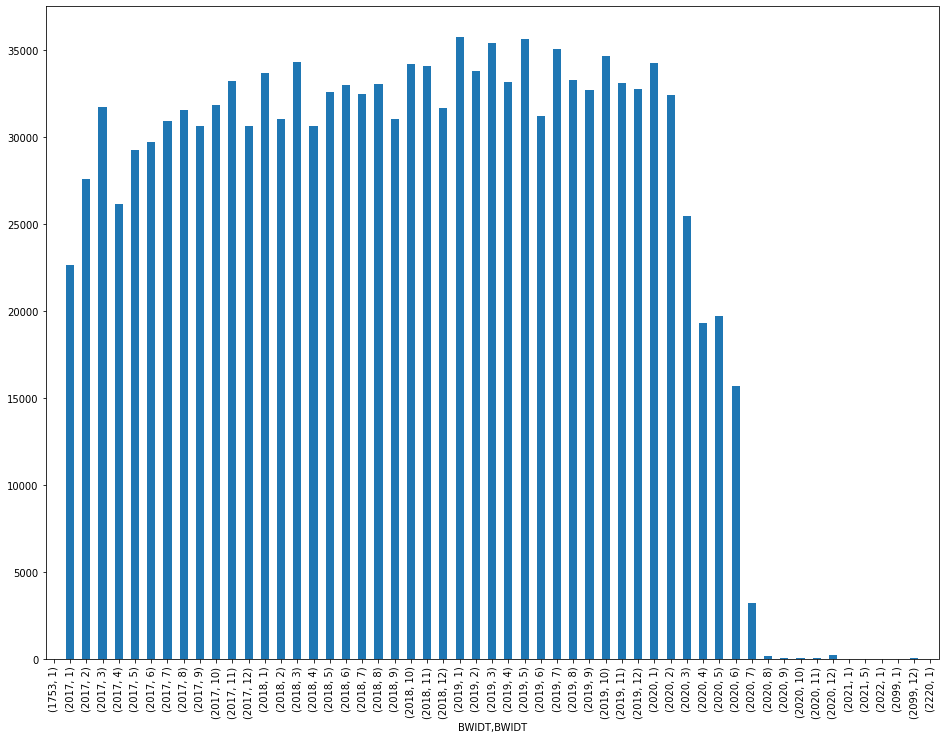

In [90]:
plot_date_histogram_of_col(movement_df, col="BWIDT", by_month=True)

In [91]:
movement_df.loc[movement_df["BWEDT"].str.contains("1[0-6][0-9][0-9]-"), "BWEDT"] = "1753-01-01"

In [92]:
movement_df.loc[movement_df["BWEDT"].str.contains("2[4-9][0-9][0-9]-"), "BWEDT"] = "1753-01-01"

In [93]:
movement_df.loc[movement_df["BWEDT"].str.contains("[3-9][0-9][0-9][0-9]-"), "BWEDT"] = "1753-01-01"

In [94]:
movement_df.loc[movement_df["BWEDT"].str.contains("0[0-9][0-9][0-9]-"), "BWEDT"] = "1753-01-01"

In [95]:
movement_df["BWEDT"] = pd.to_datetime(movement_df["BWEDT"])

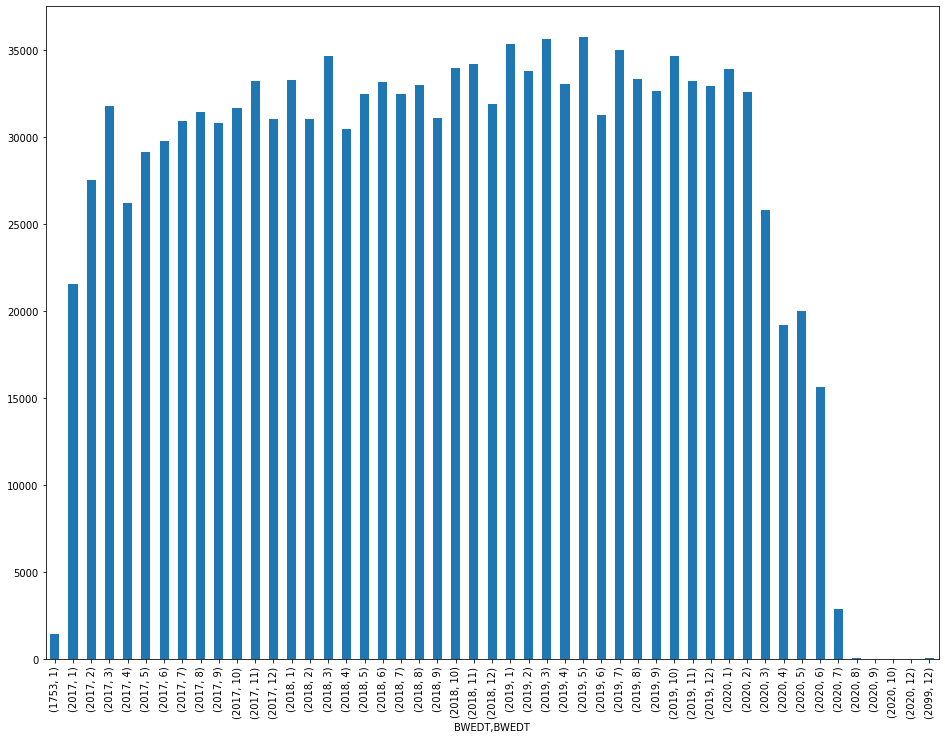

In [96]:
plot_date_histogram_of_col(movement_df, col="BWEDT", by_month=True)

In [97]:
evaluate_col_classes(movement_df)

CATEGORICAL: Column name: FALNR, dtype: object, values: ['0005729661' '0005734283' '0005734610' ... '0030092090' '0030092103'
 '0030092105']
CATEGORICAL: Column name: LFDNR, dtype: object, values: ['3' '4' '5' '6' '7' '8' '9' '10' '11' '1' '2' '16' '17' '20' '12' '13'
 '14' '15' '18' '19' '21' '22' '24' '23' '25' '26' '27' '28' '29' '30'
 '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43' '44'
 '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57' '58'
 '59' '60' '61' '62' '66' '67' '68' '69' '70' '63' '64' '65' '73' '74'
 '75' '76' '77' '78' '79' '80' '81' '84' '85' '86' '87' '95' '96' '97'
 '99' '100' '101' '102' '103' '104' '105' '107' '108' '109' '71' '72' '82'
 '83' '88' '89' '90' '92' '93' '98' '106' '110' '111' '112' '113' '114'
 '117' '118' '119' '120' '121' '122' '123' '124' '125' '126' '127' '128'
 '129' '130' '131' '132' '133' '134' '135' '136' '138' '139' '140' '141'
 '142' '143' '144' '145' '146' '147' '148' '149' '150' '151' '152' '153'
 '154' '15

CATEGORICAL: Column name: EXTKH, dtype: object, values: [nan '0010101818' '0010100302' ... '0010101851' '0010102284' '0010100664']


## LA_ISH_NDIA

In [98]:
diagnosis_df = pd.read_csv(base_folder + "LA_ISH_NDIA.csv", dtype=str, parse_dates=["DIADT"], encoding="ISO-8859-1")

In [99]:
diagnosis_df

,FALNR,DKEY1,DKAT1,DIADT,DRG_CATEGORY
0,0005741483,Y84.9,17,2017-01-16,S
1,0005741487,S64.4,17,2017-01-05,P
2,0005741487,S66.1,17,2017-01-05,S
3,0005741487,S61.0,17,2017-01-05,S
4,0005741487,S63.4,17,2017-01-05,S
...,...,...,...,...,...
1838183,0007674885,Q53.1,19,2020-06-17,P
1838184,0007674885,N50.8,19,2020-06-17,S
1838185,0007674885,Y84.9,19,2020-06-17,S
1838186,0007674991,C50.8,19,2020-06-04,P


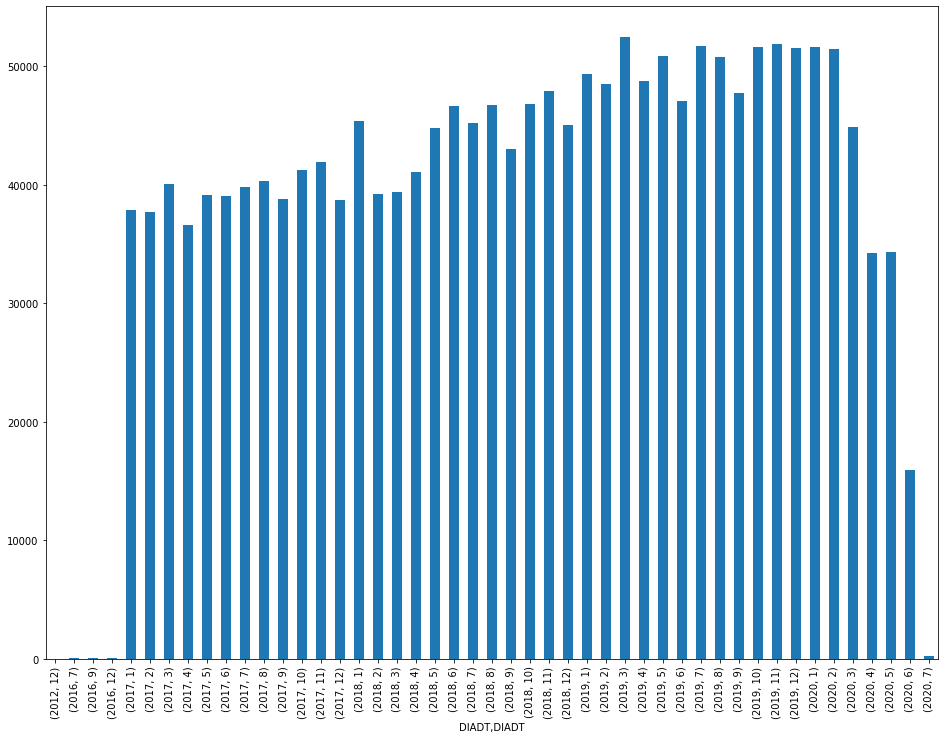

In [100]:
plot_date_histogram_of_col(diagnosis_df, col="DIADT", by_month=True)

In [101]:
evaluate_col_classes(diagnosis_df)

CATEGORICAL: Column name: FALNR, dtype: object, values: ['0005741483' '0005741487' '0005741488' ... '0007674825' '0007674849'
 '0007674885']
CATEGORICAL: Column name: DKEY1, dtype: object, values: ['Y84.9' 'S64.4' 'S66.1' ... 'U81.11' 'S25.80' 'K02.2']
CATEGORICAL: Column name: DKAT1, dtype: object, values: ['17' '15' '19' '11']
UNKNOWN: Column name: DIADT, dtype: datetime64[ns], class: numerical
CATEGORICAL: Column name: DRG_CATEGORY, dtype: object, values: ['S' 'P']


## LD_ISH_NDRG

In [102]:
drg_tarif_df = pd.read_csv(base_folder + "LA_ISH_NDRG.csv", encoding="ISO-8859-1")

In [103]:
drg_tarif_df

,PATCASEID,COST_WEIGHT
0,5729661,1.859
1,5729661,1.859
2,5734283,0.297
3,5734610,0.752
4,5734610,0.752
...,...,...
259851,30091525,0.478
259852,30091535,1.075
259853,30091569,0.294
259854,30091606,0.294


In [104]:
evaluate_col_classes(drg_tarif_df)

NUMERICAL: Column name: PATCASEID, dtype: int64, #qty unique values: 218760
NUMERICAL: Column name: COST_WEIGHT, dtype: float64, #qty unique values: 8519


## LA_ISH_NFPZ

In [105]:
partner_case_df = pd.read_csv(base_folder + "LA_ISH_NFPZ.csv", encoding="ISO-8859-1")

In [106]:
partner_case_df

,EARZT,FARZT,FALNR,LFDNR,PERNR,STORN
0,H,2,5729661,1,10202261,NaN
1,H,2,5729661,2,10202261,NaN
2,H,2,5729661,3,10202261,NaN
3,H,2,5734260,1,10216886,X
4,H,2,5734260,2,10216886,X
...,...,...,...,...,...,...
497092,H,2,30091220,2,10202536,NaN
497093,H,2,30091296,5,10221144,NaN
497094,U,5,30091352,37,10220426,NaN
497095,H,2,30091428,3,10221760,NaN


In [107]:
evaluate_col_classes(partner_case_df)

CATEGORICAL: Column name: EARZT, dtype: object, values: ['H' 'E' 'U' 'B' 'W' 'X' 'A' 'N' 'G' 'O']
NUMERICAL/POSSIBLY CATEGORICAL: Column name: FARZT, dtype: int64, unique values (#qty): [0, 1, 2, 3, 4, 5, 6, 7, 9], (9)
NUMERICAL: Column name: FALNR, dtype: int64, #qty unique values: 170642
NUMERICAL: Column name: LFDNR, dtype: int64, #qty unique values: 401
NUMERICAL: Column name: PERNR, dtype: int64, #qty unique values: 8478
CATEGORICAL: Column name: STORN, dtype: object, values: [nan 'X']


## LA_ISH_NGPA

In [108]:
external_partner_df = pd.read_csv(base_folder + "LA_ISH_NGPA.csv", encoding="ISO-8859-1")

/home/benelot/miniconda3/envs/vre-spark/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [109]:
external_partner_df

,GPART,NAME1,NAME2,NAME3,LAND,PSTLZ,ORT,ORT2,STRAS,KRKHS
0,1,NaN,NaN,NaN,CH,NaN,NaN,NaN,NaN,NaN
1,2,Swisscare Insurance AG,NaN,NaN,CH,1700,Fribourg,Fribourg,rue de Lausanne,NaN
2,4,Praxisgemeinschaft,HasliPraxis,NaN,CH,4900,Langenthal,Langenthal,St. Urbanstrasse 40,NaN
3,14,Bioanalytica,Medizinisches Labor,NaN,CH,6000,Luzern 6,Luzern 6,St. Anna-Strasse 35,NaN
4,44,Schüpbach,Isabelle,NaN,CH,3303,Jegenstorf,NaN,Bernstrasse 7,NaN
...,...,...,...,...,...,...,...,...,...,...
98774,1005005285,Steib,Moritz,NaN,CH,3010,Bern,NaN,NaN,NaN
98775,1005005286,Tavares Valdez,Ana Teresa,NaN,CH,3010,Bern,NaN,NaN,NaN
98776,1005005287,Bachofner-Weber,Kathrine,NaN,CH,3010,Bern,NaN,NaN,NaN
98777,1009000029,Nageh,Thuraia,NaN,CH,3010,Bern,NaN,NaN,NaN


In [110]:
evaluate_col_classes(external_partner_df)

NUMERICAL: Column name: GPART, dtype: int64, #qty unique values: 98779
CATEGORICAL: Column name: NAME1, dtype: object, values: [nan 'Swisscare Insurance AG' 'Praxisgemeinschaft' ... 'Tavares Valdez'
 'Bachofner-Weber' 'Nageh']
CATEGORICAL: Column name: NAME2, dtype: object, values: [nan 'HasliPraxis' 'Medizinisches Labor' ... 'Olimpia Ksenia' 'Kathrine'
 'Thuraia']
CATEGORICAL: Column name: NAME3, dtype: object, values: [nan 'Schadenabteilung' 'Spitalfinanzierung' ... 'Belegarzt Riggisberg'
 'Dr.med. P. Freiburghaus' 'Praxis Dr. K. Geisbühler']
CATEGORICAL: Column name: LAND, dtype: object, values: ['CH' 'LI' 'DE' 'US' 'NL' 'DK' 'FR' 'GB' 'BE' 'PL' 'CZ' 'AT' 'RS' 'FI'
 'HR' 'IL' 'IT' 'SI' 'IE' 'LU' 'AU' 'HU' 'ZA' 'BG' 'GR' 'ES' 'RU' 'AR'
 'MA' 'SG' 'NZ' 'MK' 'CA' 'UY' 'LB' 'PH' 'BA' 'EG' 'UA' 'NO' 'AL' 'KS'
 'IN' 'CN' 'SN' 'BR' 'MY' 'JP' 'AE' 'PT' 'DZ' 'TN' 'IS' 'IR' 'SE' 'TW'
 'ID' 'LT' 'CM' 'HK' 'LV' 'TH' nan]
CATEGORICAL: Column name: PSTLZ, dtype: object, values: [nan '1700' '4900'

## LA_ISH_NICP

In [111]:
surgery_df = pd.read_csv(base_folder + "LA_ISH_NICP.csv", dtype=str, parse_dates=["BGDOP"], encoding="ISO-8859-1")

In [112]:
surgery_df

,LFDBEW,ICPMK,ICPML,ANZOP,BGDOP,LSLOK,STORN,FALNR,ORGPF
0,0,16,37.51.10,0,2016-07-07,NaN,NaN,0005739975,INEGE 1
1,0,16,00.93.20,0,2016-07-07,NaN,NaN,0005739975,INEGE 1
2,0,16,00.99.10,0,2016-07-07,NaN,NaN,0005739975,INEGE 1
3,0,16,37.25.30,0,2016-07-07,NaN,NaN,0005739975,INEGE 1
4,0,16,37.4X.11,0,2016-07-07,NaN,NaN,0005739975,INEGE 1
...,...,...,...,...,...,...,...,...,...
1029587,0,20,97.62,0,2020-06-16,B,NaN,0007710856,VORNE 3.
1029588,0,20,99.84.15,0,2020-06-17,NaN,NaN,0007711761,KK K NO
1029589,0,20,99.84.25,0,2020-06-17,NaN,NaN,0007711761,KK K NO
1029590,0,20,83.88.41,0,2020-06-03,L,NaN,0007654160,61STAT1


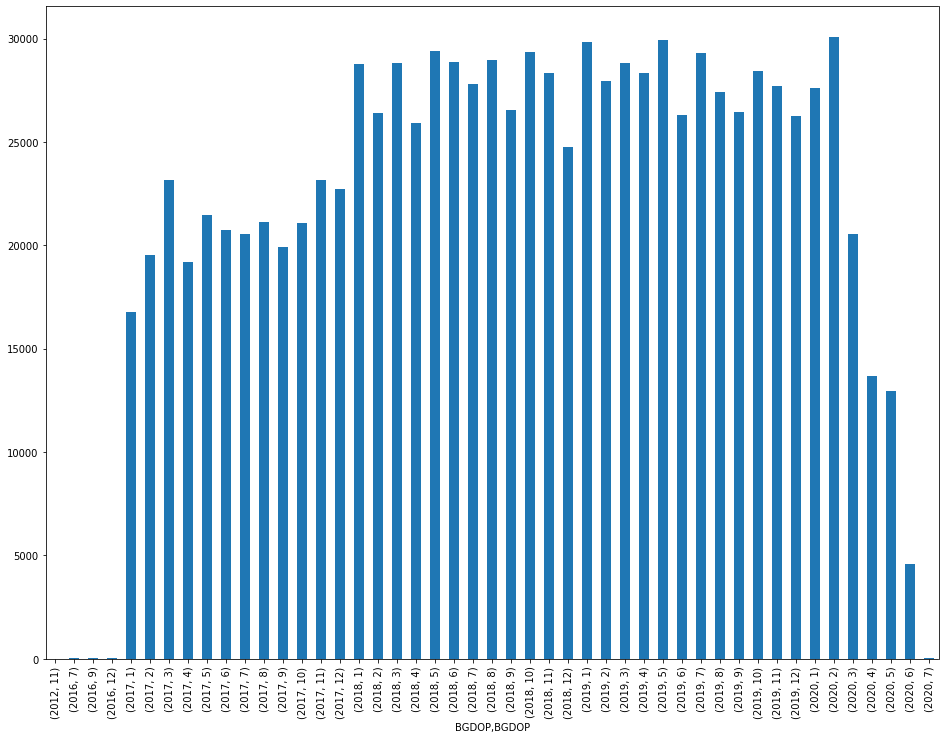

In [113]:
plot_date_histogram_of_col(surgery_df, col="BGDOP", by_month=True)

In [114]:
evaluate_col_classes(surgery_df)

CATEGORICAL: Column name: LFDBEW, dtype: object, values: ['0']
CATEGORICAL: Column name: ICPMK, dtype: object, values: ['16' '17' '18' '19' '11' '20']
CATEGORICAL: Column name: ICPML, dtype: object, values: ['37.51.10' '00.93.20' '00.99.10' ... '93.9G.71' '93.57.1D' '81.96.17']
CATEGORICAL: Column name: ANZOP, dtype: object, values: ['0']
UNKNOWN: Column name: BGDOP, dtype: datetime64[ns], class: numerical
CATEGORICAL: Column name: LSLOK, dtype: object, values: [nan 'L' 'R' 'B' 'U' 'EU']
CATEGORICAL: Column name: STORN, dtype: object, values: [nan 'X']
CATEGORICAL: Column name: FALNR, dtype: object, values: ['0005739975' '0005757921' '0005747927' ... '0007693586' '0007709754'
 '0007711761']
CATEGORICAL: Column name: ORGPF, dtype: object, values: ['INEGE 1' 'G NORD' '71WEST P' '71IPS' 'NDYL' 'HGKT' 'NEPH' 'IBME'
 'KK K SU' 'KK HS' 'Q MITTE' '71WEST 2' 'N NORD' '62STAT A' 'R MITTE1'
 'INEBL 1' '71OST 2' 'P MITTE' 'F1' '2OG' 'Q NORD' 'H SUED 2' 'N SUED'
 'J NORD' 'KK B IB' 'H NORD 2' '63S

## TACS_DATEN

In [115]:
tacs_df = pd.read_csv(base_folder + "TACS_DATEN.csv", dtype=str, parse_dates=["datum_betreuung"], encoding="ISO-8859-1")

In [116]:
tacs_df

,patient_patientid,patient_typ,patient_status,fall_nummer,fall_typ,fall_status,datum_betreuung,dauer_betreuung_in_min,mitarbeiter_personalnummer,mitarbeiter_anstellungsnummer,mitarbeiter_login,BATCH_RUN_ID
0,00014549581,Standard Patient,aktiv,0006724219,Standard Fall,aktiv,2018-10-17,60,0086309,00015652,I0086309,32343
1,00012294594,Standard Patient,aktiv,0006763222,Standard Fall,aktiv,2018-10-17,10,0078312,00010782,I0078312,32343
2,00015013642,Standard Patient,aktiv,0006753148,Standard Fall,aktiv,2018-10-17,90,0078312,00010782,I0078312,32343
3,00015013642,Standard Patient,aktiv,0006753148,Standard Fall,aktiv,2018-10-17,60,0078312,00010782,I0078312,32343
4,00007916221,Standard Patient,aktiv,0006418999,Standard Fall,aktiv,2018-05-16,14,0071448,00014921,I0071448,32343
...,...,...,...,...,...,...,...,...,...,...,...,...
14217550,00015440915,Standard Patient,aktiv,0007143486,Standard Fall,aktiv,2019-07-08,30,0324821,00043091,I0324821,32343
14217551,00015526216,Standard Patient,aktiv,0007181733,Standard Fall,aktiv,2019-07-08,70,0316865,00035816,I0316865,32343
14217552,00015526216,Standard Patient,aktiv,0007181733,Standard Fall,aktiv,2019-07-08,50,0316865,00035816,I0316865,32343
14217553,00008415714,Standard Patient,aktiv,0007179793,Standard Fall,aktiv,2019-07-08,30,5005034,00116883,B5005034,32343


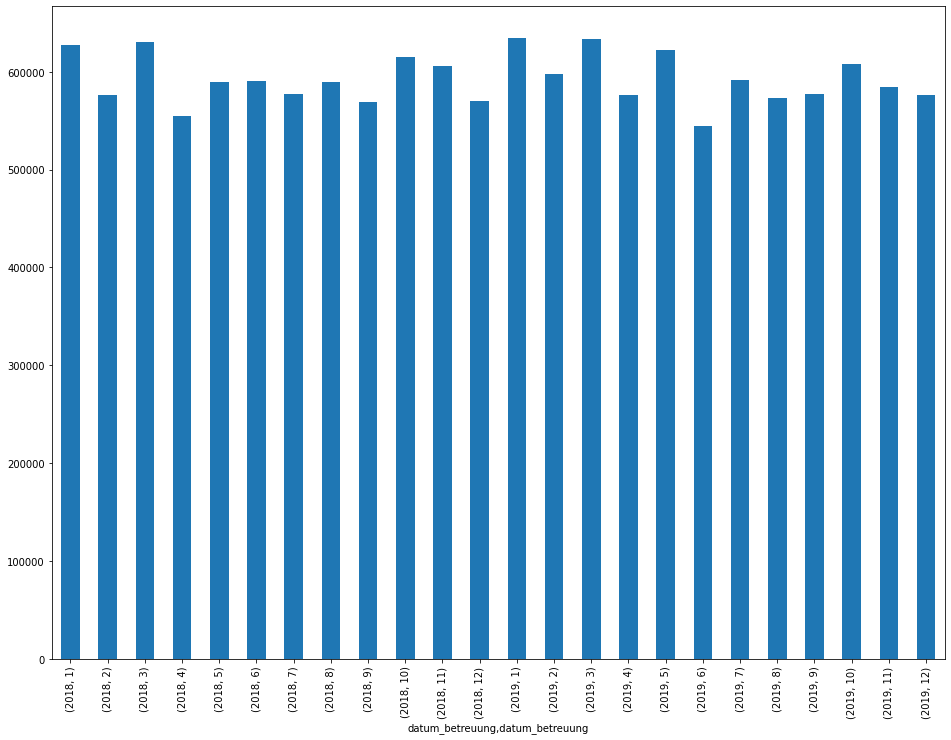

In [117]:
plot_date_histogram_of_col(tacs_df, col="datum_betreuung", by_month=True)

In [118]:
evaluate_col_classes(tacs_df)

CATEGORICAL: Column name: patient_patientid, dtype: object, values: ['00014549581' '00012294594' '00015013642' ... '00000823155' '00015329534'
 '00012512028']
CATEGORICAL: Column name: patient_typ, dtype: object, values: ['Standard Patient']
CATEGORICAL: Column name: patient_status, dtype: object, values: ['aktiv']
CATEGORICAL: Column name: fall_nummer, dtype: object, values: ['0006724219' '0006763222' '0006753148' ... '0007454226' '0007022943'
 '0007419263']
CATEGORICAL: Column name: fall_typ, dtype: object, values: ['Standard Fall']
CATEGORICAL: Column name: fall_status, dtype: object, values: ['aktiv']
UNKNOWN: Column name: datum_betreuung, dtype: datetime64[ns], class: numerical
CATEGORICAL: Column name: dauer_betreuung_in_min, dtype: object, values: ['60' '10' '90' '14' '8' '19' '5' '22' '120' '30' '45' '80' '15' '180' '4'
 '35' '25' '6' '2' '26' '1' '420' '3' '20' '130' '9' '21' '85' '70' '100'
 '96' '47' '7' '31' '40' '270' '17' '23' '44' '11' '32' '33' '13' '16'
 '12' '76' '50'

## V_LA_ISH_NDIA_NORM

In [119]:
diagnosis_norm_df = pd.read_csv(base_folder + "V_LA_ISH_NDIA_NORM.csv", dtype=str, parse_dates=["DIADT"], encoding="ISO-8859-1")

In [120]:
diagnosis_norm_df

,FALNR,DKEY1,DKAT1,DIADT,DRG_CATEGORY
0,0005737635,H34.8,17,2017-01-03,S
1,0005737635,Z92.2,17,2017-01-03,S
2,0005737635,R73.9,17,2017-01-03,S
3,0005737663,O42.29,17,2017-01-04,P
4,0005737663,O60.3,17,2017-01-04,S
...,...,...,...,...,...
1653153,0030091479,Y82.8,19,2019-12-25,S
1653154,0030091479,E53.8,19,2019-12-25,S
1653155,0030091479,L40.9,19,2019-12-25,S
1653156,0030091479,R39.1,19,2019-12-25,S


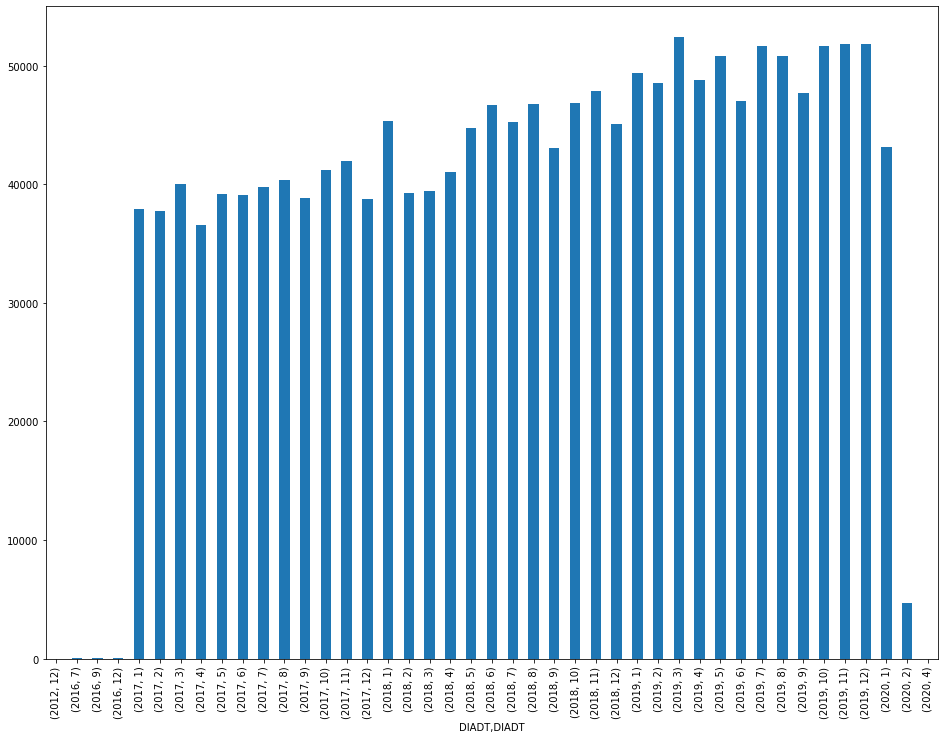

In [121]:
plot_date_histogram_of_col(diagnosis_norm_df, col="DIADT", by_month=True)

In [122]:
evaluate_col_classes(diagnosis_norm_df)

CATEGORICAL: Column name: FALNR, dtype: object, values: ['0005737635' '0005737663' '0005737667' ... '0030091436' '0030091437'
 '0030091479']
CATEGORICAL: Column name: DKEY1, dtype: object, values: ['H34.8' 'Z92.2' 'R73.9' ... 'B97.3' 'B39.3' 'A00.1']
CATEGORICAL: Column name: DKAT1, dtype: object, values: ['17' '15' '19' '11']
UNKNOWN: Column name: DIADT, dtype: datetime64[ns], class: numerical
CATEGORICAL: Column name: DRG_CATEGORY, dtype: object, values: ['S' 'P']


## VRE_SCREENING_DATA

In [123]:
vre_screening_df = pd.read_csv(base_folder + "VRE_SCREENING_DATA.csv", dtype=str, parse_dates=["Record Date", "Birth Date"], encoding="ISO-8859-1")

In [124]:
vre_screening_df

,Unnamed: 0,Order ID,Record Date,Measurement Date,First Name,Last Name,Birth Date,Patient ID,Pathogen Result
0,0,2803033,2017-12-30,2017-12-29,Roland,Streiff,1965-10-04,00013253506,nn
1,2,2803035,2017-12-30,2017-12-29,Roland,RÃ¼fenacht,1956-01-18,00006240593,nn
2,3,2803036,2017-12-30,2017-12-29,Pia,Petrick Ibele,1949-04-11,00011897031,nn
3,4,2803037,2017-12-30,2017-12-29,Roland,Steffen,1963-03-27,00014303736,nn
4,5,2803038,2017-12-30,2017-12-29,Eloina,Perez Castaedo,1944-03-13,000504077-9,nn
...,...,...,...,...,...,...,...,...,...
27471,15632,3255143,2020-08-07,2020-08-07,Lina,Heiniger,1933-12-13,6950671,nn
27472,11418,3254955,2020-08-07,2020-08-06,Mohammed,Sallam,1979-12-28,15982815,nn
27473,19175,3255465,2020-08-08,2020-08-08,Badou,Diop,1992-02-04,16219260,nn
27474,8572,3255481,2020-08-08,2020-08-08,Silvia,Siegrist Elshani,1959-05-08,12573124,nn


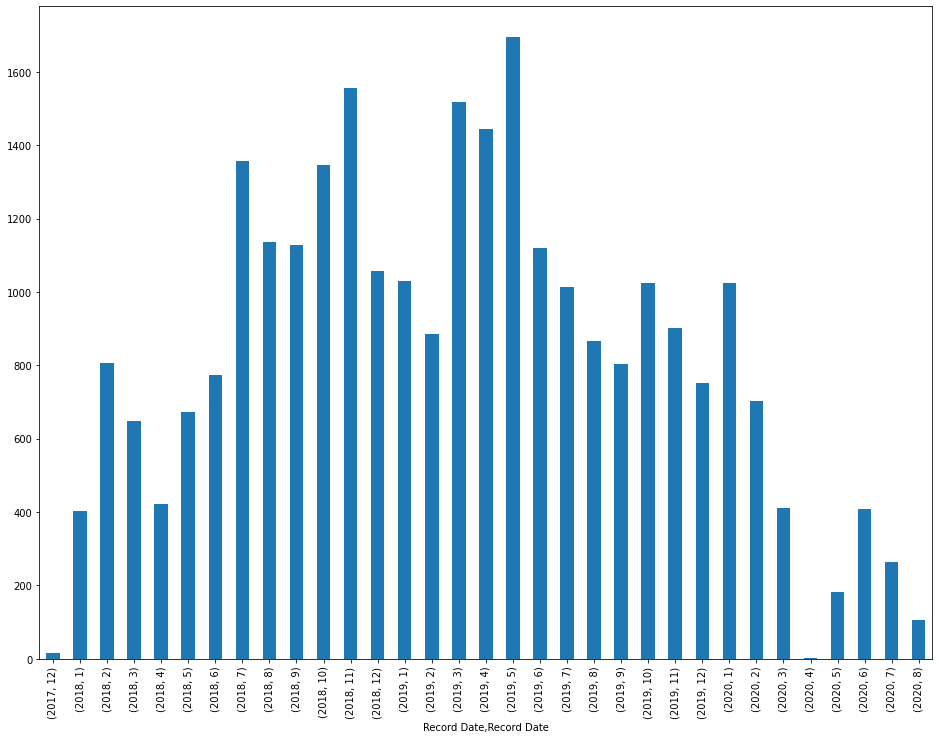

In [125]:
plot_date_histogram_of_col(vre_screening_df, col="Record Date", by_month=True)

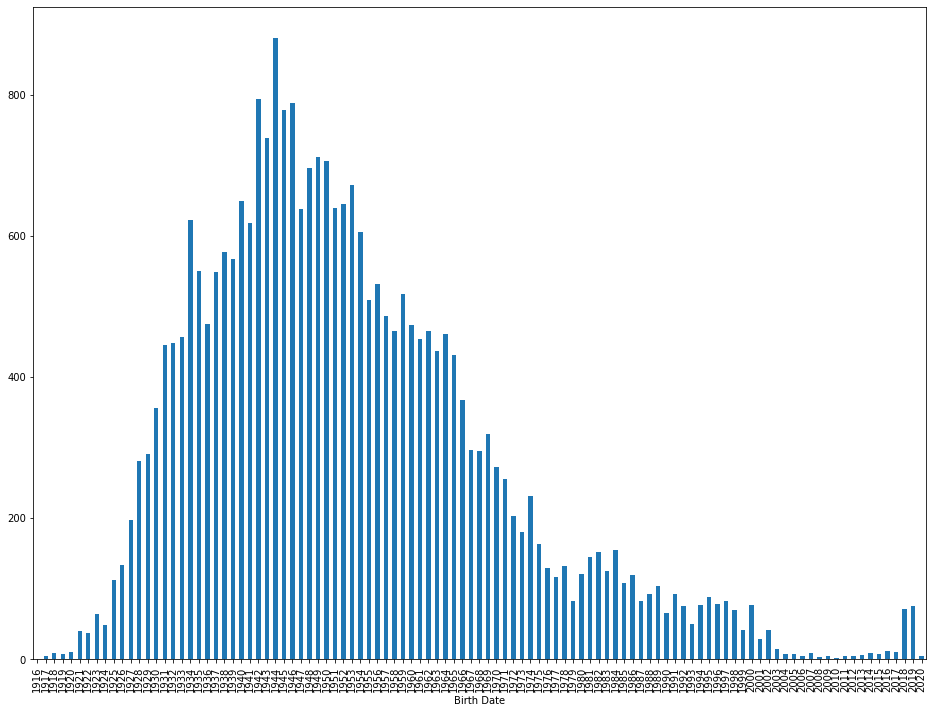

In [126]:
plot_date_histogram_of_col(vre_screening_df, col="Birth Date", by_month=False)

In [127]:
evaluate_col_classes(vre_screening_df)

CATEGORICAL: Column name: Unnamed: 0, dtype: object, values: ['0' '2' '3' ... '11418' '19175' '17477']
CATEGORICAL: Column name: Order ID, dtype: object, values: ['2803033' '2803035' '2803036' ... '3255465' '3255481' '3255507']
UNKNOWN: Column name: Record Date, dtype: datetime64[ns], class: numerical
CATEGORICAL: Column name: Measurement Date, dtype: object, values: ['2017-12-29' '2018-01-03' nan '2018-01-05' '2018-01-02' '2018-01-06'
 '2018-01-08' '2018-01-09' '2018-01-10' '2018-01-11' '2018-01-12'
 '2018-01-14' '2018-01-15' '2018-01-13' '2018-01-16' '2018-01-17'
 '2018-01-18' '2018-01-19' '2018-01-20' '2018-01-21' '2018-02-21'
 '2018-01-22' '2018-01-23' '2018-01-24' '2018-01-25' '2018-01-26'
 '2018-01-27' '2018-01-28' '2018-01-29' '2018-01-30' '2018-01-31'
 '2018-02-01' '2018-02-02' '2018-02-03' '2018-02-04' '2018-02-05'
 '2018-02-06' '2018-02-07' '2018-02-08' '2018-02-09' '2018-02-10'
 '2018-02-12' '2018-02-11' '2018-02-13' '2018-02-14' '2018-02-15'
 '2018-02-16' '2018-02-17' '2018